In [1]:
import os,sys,inspect
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from datetime import datetime
from agents.Base import deepagents, run
from agents.BlueAgents import *
from data.preprocessing import data_split, get_price, DataProcessor
import pandas as pd
import numpy as np
from agents.wrappers.ObservationWrapper import NormalizedEnv
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from env.BaseEnv import EnvConfig
from env.EnvStock_train import StockEnvTrain
from env.EnvStock_trade import StockEnvTrade
from env.EnvStock_val import StockEnvValidation
from env.crypto.SingleCryptoEnv import SingleCryptoEnv
from env.crypto.SingleCryptoEnv import SingleCryptoEnv
from env.BaseEnv import EnvConfig
from agents.BlueAgents import TrainerConfig

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [18]:
df = pd.read_csv('../datasets/dow50.csv')
df = df[df.ticker != 'BRK']
cwd = '../AgentResult'

In [19]:
indata = data_split(df, '2009-01-01','2022-09-25')

In [4]:
# Winner hparams with 3.1m ending for PPO
# environment reward is grade 0
# indicator based
# Error on reward where the agent get -500 

last_winner ={'eval_time_gap': 32, 'batch_size': 32, 
 'gamma': 0.98, 'learning_rate': 0.03372, 
 'target_step': 86175, 'net_dimension': 1026, 'episode': 3, 'seed': 42069}

rec_decay ={'eval_time_gap': 32, 'batch_size': 32, 
 'gamma': 0.98, 'learning_rate': {'start':0.03372, 'end':0.0001}, 
 'target_step': 86175, 'net_dimension': 1026, 'episode': 20, 'seed': 42069}

# Own agent

1. Winner params
'''
    model_kwargs = {
        'learning_rate':0.0027,
        'batch_size':64,
        'gamma':0.99,
        'seed':42069,
        'net_dimension':256, # Change this dimension to be more dynamic
        'target_step':5000,
        'eval_time_gap':10
    }

    model_name = 'jim-ppo-v2'
    model_type = 'ppo'

    with indicators without open high low close and without the episodic training
    
    rebalance_window = 63
    validation_window = 63
'''

- [x] Change the timesteps version make sure it does reiterate with same agent
- [x] Normalize Inputs for the model
- [x] Normalize reward function
- [ ] Vectorized paralel envs
- [x] start trading from 2016
- [x] Add PBT
- [x] Change neet dimension problem here you cannot make it another than 160 
- [x] Create summary write for tensorboard
- [ ] Imitation Learning
- [ ] Auxilary Loss
- [x] LR Decay
- [ ] Loss on sell -- loss compared to buy and hold of stock
- [ ] Stock Randomization (Automatic Domain Randomization)
- [ ] Implement shared layer and seperate networks for RNN's
- [x] **CHANGE TRAINGIN PROCESS WHERE IT CREATES TRAJECTORIES WITH THE NEW UPDATED POLCIY**
- [ ] Implement Early stopping
- [ ] Add time-frame to data /check whats added
- [x] Training with giving a stocks information together, not indicator based style
- [ ] Decision Transformer
- [ ] Win / Loss multi agent training
- [ ] kelly criterion as auxilary task / optimize kelly main obj
- [ ] Mu-law tokenization

In [20]:
MODELS = ['shared_recurrent_ppo', 'recurrent_ppo', 'PPO']

model_kwargs = {
    'learning_rate':0.0035,
    'batch_size':16,
    'gamma':0.99,
    'seed':6931,
    'net_dimension':1024, 
    'target_step':4500,
    'eval_time_gap':11,
    "episode":2 # NONE if you only want to give target step
}

second = {'eval_time_gap': 16, 'batch_size': 16, 'gamma': 0.999, 'learning_rate': 0.04498, 
          'target_step': 80242, 'net_dimension': 128, 'episode': 5, 'seed': 31} # This lost to bnh in crisis
model_name = 'jim-ppo-recurrent'
model_type = MODELS[2]
env_config = EnvConfig(stock_first_state= False, reward_grade=1)
tconfig = TrainerConfig(dataset_version = 'DOW50', 
                        population = 25, normalize_env=True, 
                        rebalance_window=126, validation_window=126)
# For trading dolars in the environment set hmax normalize which is max dollar amount to buy in one order
env_config_dollar_trade = EnvConfig(stock_first_state= False, INITIAL_ACCOUNT_BALANCE= 10000, quantity_buying=False, HMAX_NORMALIZE=500)

In [21]:
agent_builder = DRLAgent(model_name ,model_type, StockEnvTrain, 
                         StockEnvValidation, 
                         StockEnvTrade, indata, model_kwargs, tconfig, config = env_config)


In [8]:
agent_builder.run_prediction(total_timesteps=1000)

{'learning_rate': 0.0035, 'batch_size': 16, 'gamma': 0.99, 'seed': 6931, 'net_dimension': 1024, 'target_step': 4500, 'eval_time_gap': 11, 'episode': 2}
======Model training from:  2010-01-01 to  2016-01-04
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.


  0%|          | 0/2 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [22]:
agent_builder.run_pbt_prediction()

======Training Agents with the population of 25========
Agent:  0 / 25
{'learning_rate': 0.0035, 'batch_size': 16, 'gamma': 0.99, 'seed': 6931, 'net_dimension': 1024, 'target_step': 4500, 'eval_time_gap': 11, 'episode': 2}
======Model training from:  2010-01-01 to  2016-01-04
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.


 50%|█████     | 1/2 [00:29<00:29, 29.35s/it]

0  1.51e+03   -0.91 |   -0.91    1.0    125     0 |   -0.05   0.08   0.13  -0.50


 50%|█████     | 1/2 [00:57<00:57, 57.12s/it]

0  3.02e+03    4.96 |    4.96    1.2    125     0 |   -0.01   0.00   0.31  -0.50
Reached goals on 1509


| UsedTime:      57 | SavedDir: ./trained_models | Total Step: 1509
======jim-ppo-recurrent-485-agent-0 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  1509  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1065790.2427528363
total_asset_change:65790.24275283632
Total cash is: 5.959099577075477$ and total holdings in stocks are 1065784.2836532593$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  998.9950458545683
Sum of rewards  -14113563.99858696
Total trades:  148
Total buy orders are 148 and total sell orders are 0
Total days in turbulance:  0
Sharpe:  0.14970116767990974
Test Finished!
episode_return % 0.06580000000000008
Agent:  0 / 25
{'learning_rate': 0.0035, 'batch_size': 16, 'gamma': 0.99, 'seed': 6931, 'net_dimension': 1024, 'target_step': 4500, 'eval_time_gap': 11, 'episode': 2}
======Model training from:  2010-01-

  0%|          | 0/2 [00:00<?, ?it/s]

0  1.64e+03   -6.97 |   -6.97    6.9    125     0 |   -0.05   0.02   0.07  -0.50


100%|██████████| 2/2 [01:01<00:00, 30.81s/it]

0  3.27e+03   -3.60 |   -3.60    0.2    125     0 |   -0.01   0.00   0.33  -0.50


100%|██████████| 2/2 [01:01<00:00, 30.97s/it]


| UsedTime:      62 | SavedDir: ./trained_models | Total Step: 1635
======jim-ppo-recurrent-485-agent-0 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  3144  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-0.csv
previous_total_asset:1065790.2427528363
end_total_asset:1199379.468122765
total_asset_change:133589.22536992864
Total cash is: 16.100906654617123$ and total holdings in stocks are 1199363.3672161102$
Buy & Hold strategy with previous total asset:  1192734.1805875853
Total Cost:  1610.0515046138755
Sum of rewards  -2335441.2837832803
Total trades:  215
Total buy orders are 120 and total sell orders are 95
Total days in turbulance:  0
Sharpe:  0.37298998614020706
Test Finished!
episode_return % 0.19940000000000002
Agent:  0 / 25
{'learning_rate': 0.0035, 'batch_size': 16, 'gamma': 0.99, 'seed': 6931, 'net_dimension': 1024,

  0%|          | 0/2 [00:00<?, ?it/s]

0  1.76e+03   -7.22 |   -7.22    6.1    125     0 |   -0.05   0.01   0.38  -0.50


100%|██████████| 2/2 [01:04<00:00, 32.37s/it]

0  3.52e+03   -2.81 |   -2.81    0.1    125     0 |   -0.01   0.00   0.36  -0.50


100%|██████████| 2/2 [01:04<00:00, 32.50s/it]


| UsedTime:      65 | SavedDir: ./trained_models | Total Step: 1761
======jim-ppo-recurrent-485-agent-0 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  4905  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-0.csv
previous_total_asset:1199379.468122765
end_total_asset:1294412.080892563
total_asset_change:95032.61276979814
Total cash is: 2.2240238192960007$ and total holdings in stocks are 1294409.856868744$
Buy & Hold strategy with previous total asset:  1361800.9804248142
Total Cost:  1525.7420485458376
Sum of rewards  -8729703.385648372
Total trades:  187
Total buy orders are 91 and total sell orders are 96
Total days in turbulance:  0
Sharpe:  0.2230730595616649
Test Finished!
episode_return % 0.2944
Agent:  0 / 25
{'learning_rate': 0.0035, 'batch_size': 16, 'gamma': 0.99, 'seed': 6931, 'net_dimension': 1024, 'target_step': 450

  0%|          | 0/2 [00:00<?, ?it/s]

0  1.89e+03    6.60 |    6.60    6.6    125     0 |   -0.05   0.02   0.04  -0.49


  0%|          | 0/2 [00:33<?, ?it/s]

Reached goals on 1888
| UsedTime:      34 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-0 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  5849  times
======Trading from:  2018-01-03 to  2018-07-05


Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-0.csv
previous_total_asset:1294412.080892563
end_total_asset:1290958.4053504567
total_asset_change:-3453.6755421063863
Total cash is: 3.893597374378235$ and total holdings in stocks are 1290954.5117530823$
Buy & Hold strategy with previous total asset:  1328467.273888313
Total Cost:  1716.332070579528
Sum of rewards  4855450.274488218
Total trades:  210
Total buy orders are 108 and total sell orders are 102
Total days in turbulance:  0
Sharpe:  0.00919335536413042
Test Finished!
episode_return % 0.2909999999999999
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {'learning_rate': 0.0035, 'batch_size': 16, 'gamma': 0.99, 'seed': 6931, 'net_dimension': 1024, 'target_step': 4500, 'eval_time_gap': 11, 'episode': 2}
Agent:  1 / 25
{'eval_time_gap': 2048, 'batch_size': 128, 'gamma': 0.9, 'learning_rate': 0.04932, 'target_step':

  0%|          | 0/7 [00:00<?, ?it/s]

0  1.51e+03    5.54 |    5.54    2.5    125     0 |   -0.05   0.14   0.09  -0.49
Reached goals on 1510


  0%|          | 0/7 [00:21<?, ?it/s]


| UsedTime:      22 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-1 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  5943  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1112683.6321985063
total_asset_change:112683.63219850627
Total cash is: 8.201728993442035$ and total holdings in stocks are 1112675.430469513$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1307.0426057716088
Sum of rewards  -9682461.76526884
Total trades:  185
Total buy orders are 172 and total sell orders are 13
Total days in turbulance:  0
Sharpe:  0.251175242397117
Test Finished!
episode_return % 0.11270000000000002
Agent:  1 / 25
{'eval_time_gap': 2048, 'batch_size': 128, 'gamma': 0.9, 'learning_rate': 0.04932, 'target_step': 32874, 'net_dimension': 100, 'episode': 7, 'seed': 42069}
======Model training from:  2010-

  0%|          | 0/7 [00:00<?, ?it/s]

0  1.64e+03   -7.23 |   -7.23    6.7    125     0 |   -0.05   0.13   0.26  -0.45


 14%|█▍        | 1/7 [00:23<02:18, 23.03s/it]

0  3.27e+03   -7.23 |   -7.66    0.4    125     0 |   -0.00   0.01   0.22  -0.45


 43%|████▎     | 3/7 [01:00<01:20, 20.19s/it]

0  4.90e+03   -4.85 |   -4.85    0.1    125     0 |   -0.00   0.02   0.37  -0.45


 57%|█████▋    | 4/7 [01:15<00:54, 18.14s/it]

0  6.54e+03   -4.85 |   -6.69    0.1    125     0 |   -0.01   0.02   0.27  -0.45


 71%|███████▏  | 5/7 [01:30<00:34, 17.11s/it]

0  8.17e+03   -4.85 |   -7.77    0.2    125     0 |   -0.01   0.05   0.30  -0.45


 86%|████████▌ | 6/7 [01:45<00:16, 16.38s/it]

0  9.80e+03   -4.85 |   -6.87    0.1    125     0 |   -0.00   0.03   0.36  -0.45


100%|██████████| 7/7 [02:00<00:00, 17.24s/it]

0  1.14e+04   -4.85 |   -6.64    0.1    125     0 |   -0.01   0.04   0.38  -0.45
| UsedTime:     121 | SavedDir: ./trained_models | Total Step: 1630
======jim-ppo-recurrent-485-agent-1 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  6655  times
======Trading from:  2017-01-03 to  2017-07-05


Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-1.csv
previous_total_asset:1112683.6321985063
end_total_asset:1196827.7857716589
total_asset_change:84144.15357315261
Total cash is: 10.057620337526942$ and total holdings in stocks are 1196817.7281513214$
Buy & Hold strategy with previous total asset:  1245212.9387820587
Total Cost:  1242.921561124801
Sum of rewards  -9755962.67287879
Total trades:  187
Total buy orders are 125 and total sell orders are 62
Total days in turbulance:  0
Sharpe:  0.21283602993927414
Test Finished!
episode_return % 0.19680000000000009
Agent:  1 / 25
{'eval_time_gap': 2048, 'batch_size': 128, 'gamma': 0.9, 'learning_rate': 0.04932, 'target_step': 32874, 'net_dimension': 100, 'episode': 7, 'seed': 42069}
======Model training from:  2010-01-01 to  2017-01-03
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    a

  0%|          | 0/7 [00:00<?, ?it/s]

0  1.76e+03   -7.05 |   -7.05    5.6    125     0 |   -0.05   0.17   0.14  -0.40


 14%|█▍        | 1/7 [00:23<02:23, 23.99s/it]

0  3.52e+03   -7.05 |   -8.71    0.7    125     0 |   -0.01   0.03   0.35  -0.40


 43%|████▎     | 3/7 [01:03<01:24, 21.16s/it]

0  5.28e+03   -1.72 |   -1.72    0.1    125     0 |   -0.01   0.02   0.36  -0.40


 57%|█████▋    | 4/7 [01:26<01:05, 21.95s/it]

0  7.04e+03   -0.35 |   -0.35    0.0    125     0 |   -0.00   0.01   0.31  -0.40


 71%|███████▏  | 5/7 [01:42<00:39, 19.82s/it]

0  8.80e+03   -0.35 |   -2.67    0.0    125     0 |   -0.01   0.02   0.37  -0.40
0  1.06e+04   -0.35 |   -7.56    0.2    125     0 |   -0.01   0.03   0.26  -0.40


 86%|████████▌ | 6/7 [01:58<00:18, 18.54s/it]

0  1.23e+04   -0.35 |   -3.13    0.0    125     0 |   -0.00   0.04   0.36  -0.40


100%|██████████| 7/7 [02:14<00:00, 19.25s/it]


| UsedTime:     135 | SavedDir: ./trained_models | Total Step: 1756
======jim-ppo-recurrent-485-agent-1 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  7421  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-1.csv
previous_total_asset:1196827.7857716589
end_total_asset:1382040.8619671175
total_asset_change:185213.07619545865
Total cash is: 6.083482772942244$ and total holdings in stocks are 1382034.7784843445$
Buy & Hold strategy with previous total asset:  1358903.7459633073
Total Cost:  999.2118475637436
Sum of rewards  4436253.661290312
Total trades:  166
Total buy orders are 87 and total sell orders are 79
Total days in turbulance:  0
Sharpe:  0.49222992021850026
Test Finished!
episode_return % 0.3819999999999999
Agent:  1 / 25
{'eval_time_gap': 2048, 'batch_size': 128, 'gamma': 0.9, 'learning_rate': 0.04932, 'target_step': 32

 14%|█▍        | 1/7 [00:25<02:32, 25.36s/it]

0  1.89e+03   -3.30 |   -3.30    2.1    125     0 |   -0.05   0.12   0.26  -0.41
0  3.78e+03    4.03 |    4.03    0.7    125     0 |   -0.01   0.05   0.41  -0.41


 14%|█▍        | 1/7 [00:49<04:59, 49.94s/it]

Reached goals on 1887
| UsedTime:      50 | SavedDir: ./trained_models | Total Step: 1887
======jim-ppo-recurrent-485-agent-1 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  7656  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0


Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-1.csv
previous_total_asset:1382040.8619671175
end_total_asset:1427675.0844716283
total_asset_change:45634.22250451078
Total cash is: 22.133606836482528$ and total holdings in stocks are 1427652.9508647919$
Buy & Hold strategy with previous total asset:  1418401.5147894004
Total Cost:  1282.3279067134858
Sum of rewards  4193129.606616862
Total trades:  171
Total buy orders are 90 and total sell orders are 81
Total days in turbulance:  0
Sharpe:  0.05478110867235171
Test Finished!
episode_return % 0.42769999999999997
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {'eval_time_gap': 2048, 'batch_size': 128, 'gamma': 0.9, 'learning_rate': 0.04932, 'target_step': 32874, 'net_dimension': 100, 'episode': 7, 'seed': 42069}
value should be one of int, float, str, bool, or torch.Tensor
Could not write the haparms {'eval_time_gap': 2048, 'batch_size': 1

  0%|          | 0/8 [00:22<?, ?it/s]

0  1.51e+03    5.79 |    5.79    1.4    125     0 |   -0.05   0.06   0.32  -0.50
Reached goals on 1510


| UsedTime:      22 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-2 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  7844  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1039722.770120131
total_asset_change:39722.77012013097
Total cash is: 1.802012907407411$ and total holdings in stocks are 1039720.9681072235$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1066.098552632724
Sum of rewards  -16382768.033450594
Total trades:  143
Total buy orders are 136 and total sell orders are 7
Total days in turbulance:  0
Sharpe:  0.08483183931168416
Test Finished!
episode_return % 0.03970000000000007
Agent:  2 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.999, 'learning_rate': 0.02726, 'target_step': 20529, 'net_dimension': 256, 'episode': 8, 'seed': 42069}
======Model training from:  2010-

  0%|          | 0/8 [00:00<?, ?it/s]

0  1.64e+03   -7.08 |   -7.08    6.7    125     0 |   -0.05   0.07   0.29  -0.54


 12%|█▎        | 1/8 [00:24<02:48, 24.00s/it]

0  3.27e+03   -7.08 |   -7.15    0.3    125     0 |   -0.00   0.13   0.56  -0.54


 38%|███▊      | 3/8 [01:03<01:46, 21.21s/it]

0  4.90e+03   -3.84 |   -3.84    0.1    125     0 |   -0.01   0.57   0.31  -0.54


 50%|█████     | 4/8 [01:19<01:16, 19.06s/it]

0  6.54e+03   -3.84 |   -4.39    0.0    125     0 |   -0.02   0.41   0.26  -0.54
0  8.17e+03   -3.84 |   -5.30    0.0    125     0 |   -0.02   0.48   0.32  -0.54


 75%|███████▌  | 6/8 [01:51<00:34, 17.29s/it]

0  9.80e+03   -3.84 |   -6.33    0.0    125     0 |   -0.00   0.39   0.38  -0.54


 88%|████████▊ | 7/8 [02:07<00:16, 16.84s/it]

0  1.14e+04   -3.84 |   -5.06    0.0    125     0 |   -0.01   0.35   0.27  -0.54


100%|██████████| 8/8 [02:23<00:00, 17.93s/it]

0  1.31e+04   -3.84 |   -6.90    0.1    125     0 |   -0.01   0.55   0.28  -0.54
| UsedTime:     143 | SavedDir: ./trained_models | Total Step: 1629


======jim-ppo-recurrent-485-agent-2 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  9473  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-2.csv
previous_total_asset:1039722.770120131
end_total_asset:1179997.7185915913
total_asset_change:140274.94847146038
Total cash is: 5.521121880006376$ and total holdings in stocks are 1179992.1974697113$
Buy & Hold strategy with previous total asset:  1163561.8684727245
Total Cost:  882.4139419460295
Sum of rewards  -1903231.0910515361
Total trades:  117
Total buy orders are 63 and total sell orders are 54
Total days in turbulance:  0
Sharpe:  0.36107661454896056
Test Finished!
episode_return % 0.17999999999999994
Agent:  2 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.999, 'learning_rate': 0.02726, 'target_step': 20529, 'net_dimension': 256, 'episode': 8, 'seed': 42069}
======Model

  0%|          | 0/8 [00:00<?, ?it/s]

0  1.76e+03   -6.40 |   -6.40    6.1    125     0 |   -0.05   0.07   0.35  -0.52


 25%|██▌       | 2/8 [00:42<02:01, 20.29s/it]

0  3.52e+03   -6.40 |   -8.39    0.8    125     0 |   -0.01   0.03   0.31  -0.52


 38%|███▊      | 3/8 [01:06<01:51, 22.29s/it]

0  5.28e+03   -2.56 |   -2.56    0.1    125     0 |   -0.01   0.07   0.33  -0.52


 50%|█████     | 4/8 [01:23<01:20, 20.17s/it]

0  7.04e+03   -2.56 |   -4.75    0.0    125     0 |   -0.01   0.01   0.27  -0.52


 62%|██████▎   | 5/8 [01:40<00:56, 18.97s/it]

0  8.80e+03   -2.56 |   -4.74    0.0    125     0 |   -0.01   0.02   0.30  -0.52


 75%|███████▌  | 6/8 [01:57<00:36, 18.37s/it]

0  1.06e+04   -2.56 |   -4.74    0.0    125     0 |   -0.01   0.02   0.36  -0.52
0  1.23e+04   -2.56 |   -4.74    0.0    125     0 |   -0.01   0.02   0.30  -0.52


 88%|████████▊ | 7/8 [02:14<00:17, 17.97s/it]

0  1.41e+04   -2.56 |   -4.74    0.0    125     0 |   -0.01   0.02   0.36  -0.52


100%|██████████| 8/8 [02:32<00:00, 19.04s/it]


| UsedTime:     152 | SavedDir: ./trained_models | Total Step: 1755
======jim-ppo-recurrent-485-agent-2 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  11228  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-2.csv
previous_total_asset:1179997.7185915913
end_total_asset:1308387.1765644213
total_asset_change:128389.45797282993
Total cash is: 7.7023708481681155$ and total holdings in stocks are 1308379.474193573$
Buy & Hold strategy with previous total asset:  1339794.5294095972
Total Cost:  965.5302702732089
Sum of rewards  -10684671.864763832
Total trades:  120
Total buy orders are 57 and total sell orders are 63
Total days in turbulance:  0
Sharpe:  0.28040913572069526
Test Finished!
episode_return % 0.3084
Agent:  2 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.999, 'learning_rate': 0.02726, 'target_step': 20529, 'net_

  0%|          | 0/8 [00:26<?, ?it/s]

0  1.89e+03    7.02 |    7.02    6.8    125     0 |   -0.05   0.04   0.34  -0.48
Reached goals on 1888


| UsedTime:      27 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-2 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  11464  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-2.csv
previous_total_asset:1308387.1765644213
end_total_asset:1357138.9157247422
total_asset_change:48751.739160320954
Total cash is: 8.1999902603728$ and total holdings in stocks are 1357130.7157344818$
Buy & Hold strategy with previous total asset:  1342810.045810466
Total Cost:  1208.9556876095426
Sum of rewards  11382676.908773795
Total trades:  137
Total buy orders are 93 and total sell orders are 44
Total days in turbulance:  0
Sharpe:  0.05860923745165125
Test Finished!
episode_return % 0.3571
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {'eva

  0%|          | 0/14 [00:00<?, ?it/s]

0  1.51e+03    4.06 |    4.06    1.2    125     0 |   -0.05   0.01   0.22  -0.48


  0%|          | 0/14 [00:21<?, ?it/s]

Reached goals on 1510
| UsedTime:      22 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-3 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  11652  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0


previous_total_asset:1000000
end_total_asset:1079583.5657432145
total_asset_change:79583.56574321445
Total cash is: 0.737180732603278$ and total holdings in stocks are 1079582.8285624818$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1009.2667648126998
Sum of rewards  -14332333.767661596
Total trades:  192
Total buy orders are 181 and total sell orders are 11
Total days in turbulance:  0
Sharpe:  0.18762158074158458
Test Finished!
episode_return % 0.0795999999999999
Agent:  3 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.98, 'learning_rate': 0.02147, 'target_step': 59540, 'net_dimension': 100, 'episode': 14, 'seed': 31}
======Model training from:  2010-01-01 to  2016-07-05
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.


  7%|▋         | 1/14 [00:24<05:12, 24.05s/it]

0  1.64e+03   -7.48 |   -7.48    6.2    125     0 |   -0.05   0.10   0.25  -0.49


 14%|█▍        | 2/14 [00:39<03:49, 19.13s/it]

0  3.27e+03   -7.48 |   -9.05    0.6    125     0 |   -0.01   0.00   0.28  -0.49


 21%|██▏       | 3/14 [00:55<03:12, 17.53s/it]

0  4.90e+03   -7.48 |   -9.00    0.6    125     0 |    0.00   0.12   0.28  -0.49
0  6.54e+03   -5.15 |   -5.15    0.1    125     0 |   -0.00   0.10   0.34  -0.49


 36%|███▌      | 5/14 [01:33<02:44, 18.23s/it]

0  8.17e+03   -5.15 |   -5.26    0.0    125     0 |    0.00   0.13   0.34  -0.49


 43%|████▎     | 6/14 [01:57<02:38, 19.85s/it]

0  9.80e+03   -4.43 |   -4.43    0.1    125     0 |   -0.00   0.08   0.34  -0.49


 50%|█████     | 7/14 [02:12<02:09, 18.51s/it]

0  1.14e+04   -4.43 |   -5.68    0.0    125     0 |   -0.00   0.13   0.39  -0.49


 57%|█████▋    | 8/14 [02:28<01:45, 17.65s/it]

0  1.31e+04   -4.43 |   -5.03    0.0    125     0 |   -0.00   0.09   0.43  -0.49


 64%|██████▍   | 9/14 [02:44<01:24, 17.00s/it]

0  1.47e+04   -4.43 |   -6.31    0.0    125     0 |   -0.01   0.11   0.34  -0.49


 71%|███████▏  | 10/14 [02:59<01:06, 16.59s/it]

0  1.63e+04   -4.43 |   -6.39    0.0    125     0 |   -0.00   0.10   0.40  -0.49


 79%|███████▊  | 11/14 [03:15<00:48, 16.33s/it]

0  1.79e+04   -4.43 |   -7.04    0.0    125     0 |   -0.00   0.10   0.32  -0.49
0  1.96e+04   -4.43 |   -6.92    0.0    125     0 |   -0.00   0.11   0.34  -0.49


 86%|████████▌ | 12/14 [03:31<00:32, 16.12s/it]

0  2.12e+04   -4.43 |   -4.97    0.0    125     0 |    0.00   0.15   0.37  -0.49


100%|██████████| 14/14 [04:03<00:00, 16.08s/it]

0  2.28e+04   -4.43 |   -5.00    0.0    125     0 |   -0.00   0.14   0.31  -0.49


100%|██████████| 14/14 [04:03<00:00, 17.37s/it]


| UsedTime:     243 | SavedDir: ./trained_models | Total Step: 1623
======jim-ppo-recurrent-485-agent-3 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  14498  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-3.csv
previous_total_asset:1079583.5657432145
end_total_asset:1212762.2559008463
total_asset_change:133178.69015763188
Total cash is: 0.3879410358573949$ and total holdings in stocks are 1212761.8679598104$
Buy & Hold strategy with previous total asset:  1208170.3960215107
Total Cost:  1222.727871933628
Sum of rewards  -1992271.1159378055
Total trades:  213
Total buy orders are 116 and total sell orders are 97
Total days in turbulance:  0
Sharpe:  0.3156503411370507
Test Finished!
episode_return % 0.2128000000000001
Agent:  3 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.98, 'learning_rate': 0.02147, 'target_step': 

  0%|          | 0/14 [00:00<?, ?it/s]

0  1.76e+03   -6.78 |   -6.78    5.8    125     0 |   -0.05   0.08   0.05  -0.45


  7%|▋         | 1/14 [00:25<05:28, 25.24s/it]

0  3.52e+03   -1.04 |   -1.04    0.0    125     0 |   -0.01   0.00   0.33  -0.45


 21%|██▏       | 3/14 [01:06<03:52, 21.13s/it]

0  5.28e+03   -1.04 |   -6.74    0.2    125     0 |    0.01   0.04   0.36  -0.45


 29%|██▊       | 4/14 [01:23<03:15, 19.55s/it]

0  7.04e+03   -1.04 |   -1.86    0.0    125     0 |   -0.01   0.03   0.49  -0.45
0  8.80e+03    0.93 |    0.93    0.0    125     0 |   -0.01   0.01   0.29  -0.45


 43%|████▎     | 6/14 [02:04<02:37, 19.75s/it]

0  1.06e+04    0.93 |   -2.11    0.0    125     0 |   -0.01   0.01   0.37  -0.45
0  1.23e+04    0.93 |    0.83    0.0    125     0 |   -0.01   0.01   0.28  -0.45


 57%|█████▋    | 8/14 [02:45<02:03, 20.52s/it]

0  1.41e+04    2.55 |    2.55    0.1    125     0 |   -0.01   0.00   0.40  -0.45


 64%|██████▍   | 9/14 [03:02<01:36, 19.36s/it]

0  1.58e+04    2.55 |   -1.68    0.0    125     0 |   -0.01   0.00   0.41  -0.45


 71%|███████▏  | 10/14 [03:19<01:14, 18.63s/it]

0  1.76e+04    2.55 |   -0.96    0.0    125     0 |   -0.01   0.00   0.36  -0.45
0  1.93e+04    2.55 |    0.59    0.0    125     0 |   -0.02   0.01   0.30  -0.45


 86%|████████▌ | 12/14 [03:53<00:35, 17.73s/it]

0  2.11e+04    2.55 |    0.43    0.0    125     0 |   -0.01   0.02   0.42  -0.45


 93%|█████████▎| 13/14 [04:09<00:17, 17.38s/it]

0  2.28e+04    2.55 |   -1.22    0.1    125     0 |   -0.01   0.01   0.44  -0.45


100%|██████████| 14/14 [04:26<00:00, 17.16s/it]

0  2.46e+04    2.55 |    0.28    0.0    125     0 |   -0.01   0.01   0.38  -0.45


100%|██████████| 14/14 [04:26<00:00, 19.04s/it]


| UsedTime:     267 | SavedDir: ./trained_models | Total Step: 1749
======jim-ppo-recurrent-485-agent-3 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  17564  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-3.csv
previous_total_asset:1212762.2559008463
end_total_asset:1301396.119599306
total_asset_change:88633.8636984597
Total cash is: 0.2889386040169146$ and total holdings in stocks are 1301395.830660702$
Buy & Hold strategy with previous total asset:  1376996.0825600314
Total Cost:  2139.860867744142
Sum of rewards  -12142317.731144981
Total trades:  294
Total buy orders are 169 and total sell orders are 125
Total days in turbulance:  0
Sharpe:  0.23579039308565897
Test Finished!
episode_return % 0.3013999999999999
Agent:  3 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.98, 'learning_rate': 0.02147, 'target_step': 59

  0%|          | 0/14 [00:26<?, ?it/s]

0  1.89e+03    4.13 |    4.13    5.8    125     0 |   -0.05   0.08   0.10  -0.48
Reached goals on 1888


| UsedTime:      26 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-3 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  17800  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-3.csv
previous_total_asset:1301396.119599306
end_total_asset:1328765.7083732511
total_asset_change:27369.588773945114
Total cash is: 6.234965505828207$ and total holdings in stocks are 1328759.4734077454$
Buy & Hold strategy with previous total asset:  1335635.0583971532
Total Cost:  2095.7901642058614
Sum of rewards  -9012836.988345949
Total trades:  363
Total buy orders are 220 and total sell orders are 143
Total days in turbulance:  0
Sharpe:  0.04289107422573989
Test Finished!
episode_return % 0.3288
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {

  0%|          | 0/10 [00:00<?, ?it/s]

0  1.51e+03    5.83 |    5.83    1.7    125     0 |   -0.05   0.16   0.40  -0.51


  0%|          | 0/10 [00:30<?, ?it/s]


Reached goals on 1510
| UsedTime:      31 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-4 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  19310  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1078776.4004210166
total_asset_change:78776.40042101662
Total cash is: 8.194738189976142$ and total holdings in stocks are 1078768.2056828267$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1485.3814564086972
Sum of rewards  -14309765.7581918
Total trades:  287
Total buy orders are 249 and total sell orders are 38
Total days in turbulance:  0
Sharpe:  0.19014143667843283
Test Finished!
episode_return % 0.07879999999999998
Agent:  4 / 25
{'eval_time_gap': 8, 'batch_size': 8, 'gamma': 0.9999, 'learning_rate': {'start': 0.02179, 'end': 0.00042}, 'target_step': 58292, 'net_dimension': 100, 'episode': 1

 10%|█         | 1/10 [00:33<05:02, 33.58s/it]

0  1.64e+03   -7.32 |   -7.32    6.6    125     0 |   -0.05   0.04   0.17  -0.51


 20%|██        | 2/10 [01:05<04:22, 32.78s/it]

0  3.27e+03   -5.08 |   -5.08    0.0    125     0 |    0.00   0.06   0.41  -0.51


 30%|███       | 3/10 [01:37<03:47, 32.50s/it]

0  4.90e+03   -4.97 |   -4.97    0.0    125     0 |    0.01   0.11   0.14  -0.51


 40%|████      | 4/10 [02:02<02:57, 29.51s/it]

0  6.54e+03   -4.97 |   -5.02    0.0    125     0 |   -0.00   0.52   0.20  -0.51


 50%|█████     | 5/10 [02:35<02:32, 30.45s/it]

0  8.17e+03   -4.80 |   -4.80    0.0    125     0 |   -0.00   0.30   0.17  -0.51


 60%|██████    | 6/10 [02:59<01:54, 28.59s/it]

0  9.80e+03   -4.80 |   -6.12    0.0    125     0 |   -0.00   0.25   0.12  -0.51


 70%|███████   | 7/10 [03:24<01:22, 27.40s/it]

0  1.14e+04   -4.80 |   -5.70    0.0    125     0 |   -0.00   0.44   0.28  -0.51


 80%|████████  | 8/10 [03:50<00:53, 26.66s/it]

0  1.31e+04   -4.80 |   -6.38    0.0    125     0 |   -0.00   0.26   0.46  -0.50


 90%|█████████ | 9/10 [04:15<00:26, 26.20s/it]

0  1.47e+04   -4.80 |   -5.58    0.0    125     0 |   -0.02   0.71   0.37  -0.48
0  1.63e+04   -4.80 |   -5.56    0.0    125     0 |   -0.00   0.49   0.18  -0.48


100%|██████████| 10/10 [04:40<00:00, 28.01s/it]


| UsedTime:     280 | SavedDir: ./trained_models | Total Step: 1627
======jim-ppo-recurrent-485-agent-4 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  35625  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-4.csv
previous_total_asset:1078776.4004210166
end_total_asset:1110557.3823677888
total_asset_change:31780.981946772197
Total cash is: 5.207426783943902$ and total holdings in stocks are 1110552.174941005$
Buy & Hold strategy with previous total asset:  1207267.091008431
Total Cost:  582.7239392874883
Sum of rewards  -15873339.683040563
Total trades:  109
Total buy orders are 56 and total sell orders are 53
Total days in turbulance:  0
Sharpe:  0.09061118542750127
Test Finished!
episode_return % 0.11060000000000003
Agent:  4 / 25
{'eval_time_gap': 8, 'batch_size': 8, 'gamma': 0.9999, 'learning_rate': {'start': 0.02179, 'end': 

  0%|          | 0/10 [00:00<?, ?it/s]

0  1.76e+03   -6.52 |   -6.52    6.3    125     0 |   -0.05   0.04   0.19  -0.53


 20%|██        | 2/10 [01:09<04:35, 34.47s/it]

0  3.52e+03    1.08 |    1.08    0.0    125     0 |   -0.00   0.13   0.12  -0.53


 30%|███       | 3/10 [01:36<03:37, 31.01s/it]

0  5.28e+03    1.08 |   -2.18    0.0    125     0 |   -0.01   0.43   0.53  -0.53


 40%|████      | 4/10 [02:10<03:13, 32.23s/it]

0  7.04e+03    1.94 |    1.94    0.0    125     0 |   -0.01   0.61   0.47  -0.53


 50%|█████     | 5/10 [02:36<02:31, 30.26s/it]

0  8.80e+03    1.94 |   -3.41    0.0    125     0 |   -0.01   0.59   0.28  -0.53


 60%|██████    | 6/10 [03:03<01:56, 29.11s/it]

0  1.06e+04    1.94 |    1.33    0.0    125     0 |   -0.01   0.58   0.40  -0.52


 70%|███████   | 7/10 [03:37<01:32, 30.71s/it]

0  1.23e+04    2.64 |    2.64    0.0    125     0 |   -0.01   0.68   0.37  -0.53


 80%|████████  | 8/10 [04:04<00:59, 29.53s/it]

0  1.41e+04    2.64 |   -0.13    0.5    125     0 |   -0.00   0.66   0.25  -0.52


 90%|█████████ | 9/10 [04:31<00:28, 28.66s/it]

0  1.58e+04    2.64 |    0.88    0.0    125     0 |   -0.01   1.11   0.69  -0.56


100%|██████████| 10/10 [05:05<00:00, 30.36s/it]

0  1.76e+04    3.46 |    3.46    0.1    125     0 |   -0.01   0.71   0.33  -0.56


100%|██████████| 10/10 [05:05<00:00, 30.57s/it]


| UsedTime:     306 | SavedDir: ./trained_models | Total Step: 1753
======jim-ppo-recurrent-485-agent-4 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  53200  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-4.csv
previous_total_asset:1110557.3823677888
end_total_asset:1289782.3045784358
total_asset_change:179224.92221064703
Total cash is: 0.7079600760444311$ and total holdings in stocks are 1289781.59661836$
Buy & Hold strategy with previous total asset:  1260950.4934193764
Total Cost:  1344.1331349900745
Sum of rewards  -2804161.43565579
Total trades:  232
Total buy orders are 111 and total sell orders are 121
Total days in turbulance:  0
Sharpe:  0.3627417674941386
Test Finished!
episode_return % 0.28980000000000006
Agent:  4 / 25
{'eval_time_gap': 8, 'batch_size': 8, 'gamma': 0.9999, 'learning_rate': {'start': 0.02179, 'end':

  0%|          | 0/10 [00:36<?, ?it/s]

0  1.89e+03    6.45 |    6.45    6.5    125     0 |   -0.05   0.06   0.11  -0.50
Reached goals on 1888


| UsedTime:      37 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-4 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  55088  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-4.csv
previous_total_asset:1289782.3045784358
end_total_asset:1485982.4152301175
total_asset_change:196200.11065168167
Total cash is: 9.484339147290527$ and total holdings in stocks are 1485972.9308909702$
Buy & Hold strategy with previous total asset:  1323715.6909808822
Total Cost:  1197.2741172269757
Sum of rewards  26272310.789621588
Total trades:  122
Total buy orders are 92 and total sell orders are 30
Total days in turbulance:  0
Sharpe:  0.1774421662496144
Test Finished!
episode_return % 0.486
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {'ev

  0%|          | 0/8 [00:21<?, ?it/s]

0  1.51e+03    5.84 |    5.84    2.6    125     0 |   -0.05   0.02   0.21  -0.50
Reached goals on 1510


| UsedTime:      22 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-5 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  55135  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1068413.5063927697
total_asset_change:68413.50639276975
Total cash is: 9.630147520597006$ and total holdings in stocks are 1068403.876245249$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  998.9913784740052
Sum of rewards  -17675217.449755386
Total trades:  137
Total buy orders are 137 and total sell orders are 0
Total days in turbulance:  0
Sharpe:  0.1753035380364366
Test Finished!
episode_return % 0.06840000000000002
Agent:  5 / 25
{'eval_time_gap': 1024, 'batch_size': 256, 'gamma': 0.99, 'learning_rate': 0.00586, 'target_step': 25497, 'net_dimension': 512, 'episode': 8, 'seed': 69}
======Model training from:  2010-0

 12%|█▎        | 1/8 [00:23<02:43, 23.29s/it]

0  1.64e+03   -7.01 |   -7.01    6.9    125     0 |   -0.05   0.02   0.22  -0.49


 25%|██▌       | 2/8 [00:45<02:17, 22.92s/it]

0  3.27e+03   -4.36 |   -4.36    0.1    125     0 |   -0.01   0.00   0.38  -0.49
0  4.90e+03   -4.36 |   -7.04    0.2    125     0 |   -0.01   0.00   0.29  -0.49


 50%|█████     | 4/8 [01:16<01:10, 17.71s/it]

0  6.54e+03   -4.36 |   -6.80    0.1    125     0 |   -0.01   0.00   0.36  -0.49


 62%|██████▎   | 5/8 [01:31<00:50, 16.75s/it]

0  8.17e+03   -4.36 |   -7.31    0.2    125     0 |   -0.00   0.00   0.30  -0.49
0  9.80e+03   -4.36 |   -6.14    0.1    125     0 |    0.01   0.00   0.34  -0.49


 88%|████████▊ | 7/8 [02:01<00:15, 15.92s/it]

0  1.14e+04   -4.36 |   -5.07    0.0    125     0 |   -0.01   0.00   0.35  -0.49


100%|██████████| 8/8 [02:16<00:00, 15.64s/it]

0  1.31e+04   -4.36 |   -5.94    0.0    125     0 |   -0.01   0.00   0.37  -0.49


100%|██████████| 8/8 [02:16<00:00, 17.10s/it]


| UsedTime:     137 | SavedDir: ./trained_models | Total Step: 1629
======jim-ppo-recurrent-485-agent-5 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  55540  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-5.csv
previous_total_asset:1068413.5063927697
end_total_asset:1150106.4820063892
total_asset_change:81692.97561361943
Total cash is: 3.5507522173978785$ and total holdings in stocks are 1150102.9312541718$
Buy & Hold strategy with previous total asset:  1195669.8954051272
Total Cost:  1780.8154109445074
Sum of rewards  -7302770.287482277
Total trades:  271
Total buy orders are 158 and total sell orders are 113
Total days in turbulance:  0
Sharpe:  0.21702074058378443
Test Finished!
episode_return % 0.1500999999999999
Agent:  5 / 25
{'eval_time_gap': 1024, 'batch_size': 256, 'gamma': 0.99, 'learning_rate': 0.00586, 'target_ste

 12%|█▎        | 1/8 [00:24<02:51, 24.48s/it]

0  1.76e+03   -6.35 |   -6.35    6.2    125     0 |   -0.05   0.05   0.25  -0.49
0  3.52e+03   -3.97 |   -3.97    0.1    125     0 |   -0.01   0.00   0.32  -0.49


 38%|███▊      | 3/8 [01:11<01:59, 23.87s/it]

0  5.28e+03   -2.97 |   -2.97    0.1    125     0 |   -0.01   0.02   0.39  -0.49


 50%|█████     | 4/8 [01:27<01:23, 20.80s/it]

0  7.04e+03   -2.97 |   -5.96    0.0    125     0 |    0.00   0.00   0.24  -0.49


 62%|██████▎   | 5/8 [01:51<01:05, 21.89s/it]

0  8.80e+03   -1.56 |   -1.56    0.0    125     0 |   -0.00   0.00   0.38  -0.49


 75%|███████▌  | 6/8 [02:07<00:39, 19.93s/it]

0  1.06e+04   -1.56 |   -8.26    0.2    125     0 |   -0.02   0.01   0.33  -0.49


 88%|████████▊ | 7/8 [02:24<00:18, 18.70s/it]

0  1.23e+04   -1.56 |   -6.83    0.1    125     0 |   -0.01   0.00   0.30  -0.49
0  1.41e+04   -1.56 |   -4.56    0.0    125     0 |   -0.01   0.00   0.31  -0.49


100%|██████████| 8/8 [02:40<00:00, 20.03s/it]


| UsedTime:     160 | SavedDir: ./trained_models | Total Step: 1755
======jim-ppo-recurrent-485-agent-5 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  55975  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-5.csv
previous_total_asset:1150106.4820063892
end_total_asset:1184401.0927179276
total_asset_change:34294.610711538466
Total cash is: 13.85276564354497$ and total holdings in stocks are 1184387.2399522841$
Buy & Hold strategy with previous total asset:  1305855.3830679057
Total Cost:  1135.6303310108187
Sum of rewards  -14618057.265210288
Total trades:  163
Total buy orders are 85 and total sell orders are 78
Total days in turbulance:  0
Sharpe:  0.08502237355639776
Test Finished!
episode_return % 0.1843999999999999
Agent:  5 / 25
{'eval_time_gap': 1024, 'batch_size': 256, 'gamma': 0.99, 'learning_rate': 0.00586, 'target_step

  0%|          | 0/8 [00:25<?, ?it/s]

0  1.89e+03    6.63 |    6.63    6.3    125     0 |   -0.05   0.01   0.21  -0.50
Reached goals on 1888


| UsedTime:      26 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-5 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  56034  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-5.csv
previous_total_asset:1184401.0927179276
end_total_asset:1181319.6695579481
total_asset_change:-3081.4231599795166
Total cash is: 0.9984433855284998$ and total holdings in stocks are 1181318.6711145625$
Buy & Hold strategy with previous total asset:  1215561.963658713
Total Cost:  1407.1894656098139
Sum of rewards  -6889825.712508637
Total trades:  184
Total buy orders are 111 and total sell orders are 73
Total days in turbulance:  0
Sharpe:  0.009314952268578642
Test Finished!
episode_return % 0.18130000000000002
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writ

  0%|          | 0/1 [00:00<?, ?it/s]

0  1.51e+03    5.69 |    5.69    2.8    125     0 |   -0.05   0.36   0.27  -0.52


  0%|          | 0/1 [00:24<?, ?it/s]

Reached goals on 1510
| UsedTime:      24 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-6 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  56222  times
======Trading from:  2016-07-05 to  2017-01-03


Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1081729.0895117007
total_asset_change:81729.08951170067
Total cash is: 5.051818676992266$ and total holdings in stocks are 1081724.0376930237$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1332.9193469800941
Sum of rewards  -13028825.413962753
Total trades:  183
Total buy orders are 167 and total sell orders are 16
Total days in turbulance:  0
Sharpe:  0.18479856588740864
Test Finished!
episode_return % 0.0817000000000001
Agent:  6 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.99, 'learning_rate': {'start': 0.03533, 'end': 0.00045}, 'target_step': 46930, 'net_dimension': 1026, 'episode': 1, 'seed': 42069}
======Model training from:  2010-01-01 to  2016-07-05
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.


100%|██████████| 1/1 [00:25<00:00, 25.57s/it]

0  1.64e+03   -7.04 |   -7.04    6.7    125     0 |   -0.05   0.34   0.27  -0.57


100%|██████████| 1/1 [00:25<00:00, 25.57s/it]


| UsedTime:      26 | SavedDir: ./trained_models | Total Step: 1636
======jim-ppo-recurrent-485-agent-6 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  56426  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-6.csv
previous_total_asset:1081729.0895117007
end_total_asset:1110469.1735448085
total_asset_change:28740.08403310785
Total cash is: 11.814057274912571$ and total holdings in stocks are 1110457.3594875336$
Buy & Hold strategy with previous total asset:  1210571.4684195153
Total Cost:  1831.992003345487
Sum of rewards  -12086579.358670417
Total trades:  260
Total buy orders are 158 and total sell orders are 102
Total days in turbulance:  0
Sharpe:  0.08108401367667054
Test Finished!
episode_return % 0.11050000000000004
Agent:  6 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.99, 'learning_rate': {'start': 0.03533, 'en

100%|██████████| 1/1 [00:27<00:00, 27.09s/it]

0  1.76e+03   -4.46 |   -4.46    5.2    125     0 |   -0.05   0.27   0.09  -0.51


100%|██████████| 1/1 [00:27<00:00, 27.09s/it]


| UsedTime:      27 | SavedDir: ./trained_models | Total Step: 1762
======jim-ppo-recurrent-485-agent-6 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  56646  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-6.csv
previous_total_asset:1110469.1735448085
end_total_asset:1299428.488393753
total_asset_change:188959.31484894454
Total cash is: 8.262083023175787$ and total holdings in stocks are 1299420.22631073$
Buy & Hold strategy with previous total asset:  1260850.3392439808
Total Cost:  1487.060029938697
Sum of rewards  51952.511093129404
Total trades:  231
Total buy orders are 121 and total sell orders are 110
Total days in turbulance:  0
Sharpe:  0.46483314269935755
Test Finished!
episode_return % 0.2994000000000001
Agent:  6 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.99, 'learning_rate': {'start': 0.03533, 'end': 0

  0%|          | 0/1 [00:28<?, ?it/s]

0  1.89e+03    7.02 |    7.02    7.2    125     0 |   -0.05   0.32   0.14  -0.48
Reached goals on 1888


| UsedTime:      28 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-6 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  56882  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-6.csv
previous_total_asset:1299428.488393753
end_total_asset:1323115.9719169398
total_asset_change:23687.483523186762
Total cash is: 9.171454217103019$ and total holdings in stocks are 1323106.8004627228$
Buy & Hold strategy with previous total asset:  1333615.6600137143
Total Cost:  1539.0470411214826
Sum of rewards  7477815.1945676105
Total trades:  209
Total buy orders are 129 and total sell orders are 80
Total days in turbulance:  0
Sharpe:  0.034993854191029385
Test Finished!
episode_return % 0.32309999999999994
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writin

  0%|          | 0/9 [00:00<?, ?it/s]

0  1.51e+03    3.45 |    3.45    1.6    125     0 |   -0.05   0.01   0.24  -0.50


 11%|█         | 1/9 [00:46<06:12, 46.56s/it]

0  3.02e+03    5.11 |    5.11    0.7    125     0 |   -0.00   0.00   0.30  -0.50
Reached goals on 1509


| UsedTime:      47 | SavedDir: ./trained_models | Total Step: 1509
======jim-ppo-recurrent-485-agent-7 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  57070  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1035484.9566164205
total_asset_change:35484.95661642053
Total cash is: 1.5769324453582563$ and total holdings in stocks are 1035483.3796839751$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1038.3221483275577
Sum of rewards  -18495900.504549287
Total trades:  151
Total buy orders are 145 and total sell orders are 6
Total days in turbulance:  0
Sharpe:  0.0827081123754164
Test Finished!
episode_return % 0.03550000000000009
Agent:  7 / 25
{'eval_time_gap': 128, 'batch_size': 128, 'gamma': 0.995, 'learning_rate': 0.00478, 'target_step': 31123, 'net_dimension': 1026, 'episode': 9, 'seed': 42069}
======Model training from: 

  0%|          | 0/9 [00:00<?, ?it/s]

0  1.64e+03   -7.12 |   -7.12    6.8    125     0 |   -0.05   0.06   0.28  -0.51


 11%|█         | 1/9 [00:25<03:23, 25.48s/it]

0  3.27e+03   -5.96 |   -5.96    0.3    125     0 |   -0.00   0.01   0.26  -0.51


 33%|███▎      | 3/9 [01:14<02:27, 24.65s/it]

0  4.90e+03   -4.19 |   -4.19    0.0    125     0 |    0.00   0.00   0.32  -0.51


 44%|████▍     | 4/9 [01:38<02:02, 24.46s/it]

0  6.54e+03   -4.16 |   -4.16    0.0    125     0 |   -0.01   0.00   0.42  -0.50


 56%|█████▌    | 5/9 [01:54<01:26, 21.55s/it]

0  8.17e+03   -4.16 |   -6.83    0.1    125     0 |   -0.01   0.02   0.34  -0.50


 67%|██████▋   | 6/9 [02:10<00:58, 19.66s/it]

0  9.80e+03   -4.16 |   -7.13    0.1    125     0 |    0.00   0.00   0.36  -0.50


 78%|███████▊  | 7/9 [02:26<00:36, 18.44s/it]

0  1.14e+04   -4.16 |   -5.36    0.0    125     0 |    0.00   0.00   0.32  -0.50


 89%|████████▉ | 8/9 [02:42<00:17, 17.69s/it]

0  1.31e+04   -4.16 |   -5.14    0.0    125     0 |   -0.00   0.00   0.44  -0.50


100%|██████████| 9/9 [02:59<00:00, 17.20s/it]

0  1.47e+04   -4.16 |   -5.58    0.0    125     0 |    0.01   0.02   0.33  -0.50


100%|██████████| 9/9 [02:59<00:00, 19.89s/it]


| UsedTime:     179 | SavedDir: ./trained_models | Total Step: 1628
======jim-ppo-recurrent-485-agent-7 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  57984  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-7.csv
previous_total_asset:1035484.9566164205
end_total_asset:1147636.9528343515
total_asset_change:112151.99621793092
Total cash is: 9.388229416216745$ and total holdings in stocks are 1147627.5646049352$
Buy & Hold strategy with previous total asset:  1158819.2982989014
Total Cost:  786.5983615208268
Sum of rewards  3892876.1508670123
Total trades:  98
Total buy orders are 50 and total sell orders are 48
Total days in turbulance:  0
Sharpe:  0.28311597367508445
Test Finished!
episode_return % 0.14759999999999995
Agent:  7 / 25
{'eval_time_gap': 128, 'batch_size': 128, 'gamma': 0.995, 'learning_rate': 0.00478, 'target_step':

 11%|█         | 1/9 [00:26<03:28, 26.11s/it]

0  1.76e+03   -6.39 |   -6.39    6.1    125     0 |   -0.05   0.04   0.28  -0.50


 22%|██▏       | 2/9 [00:51<03:00, 25.83s/it]

0  3.52e+03   -5.38 |   -5.38    0.1    125     0 |   -0.01   0.00   0.31  -0.50


 33%|███▎      | 3/9 [01:17<02:34, 25.68s/it]

0  5.28e+03   -4.55 |   -4.55    0.1    125     0 |   -0.01   0.00   0.38  -0.50


 44%|████▍     | 4/9 [01:42<02:08, 25.63s/it]

0  7.04e+03   -4.55 |   -4.59    0.1    125     0 |   -0.02   0.00   0.39  -0.50


 56%|█████▌    | 5/9 [02:08<01:42, 25.63s/it]

0  8.80e+03   -0.16 |   -0.16    0.0    125     0 |   -0.01   0.00   0.34  -0.50


 67%|██████▋   | 6/9 [02:25<01:08, 22.89s/it]

0  1.06e+04   -0.16 |   -6.74    0.1    125     0 |   -0.00   0.01   0.37  -0.50


 78%|███████▊  | 7/9 [02:43<00:42, 21.09s/it]

0  1.23e+04   -0.16 |   -6.92    0.1    125     0 |   -0.01   0.00   0.32  -0.50


 89%|████████▉ | 8/9 [03:00<00:19, 19.85s/it]

0  1.41e+04   -0.16 |   -7.49    0.1    125     0 |   -0.01   0.00   0.33  -0.50


100%|██████████| 9/9 [03:17<00:00, 19.09s/it]

0  1.58e+04   -0.16 |   -5.57    0.0    125     0 |   -0.01   0.00   0.32  -0.50


100%|██████████| 9/9 [03:17<00:00, 22.00s/it]


| UsedTime:     198 | SavedDir: ./trained_models | Total Step: 1754
======jim-ppo-recurrent-485-agent-7 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  58968  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-7.csv
previous_total_asset:1147636.9528343515
end_total_asset:1159766.9171575538
total_asset_change:12129.964323202381
Total cash is: 14.181522680056663$ and total holdings in stocks are 1159752.7356348739$
Buy & Hold strategy with previous total asset:  1303051.4270747856
Total Cost:  1071.2568280829269
Sum of rewards  -16612097.96684916
Total trades:  174
Total buy orders are 85 and total sell orders are 89
Total days in turbulance:  0
Sharpe:  0.035194968787970404
Test Finished!
episode_return % 0.15979999999999994
Agent:  7 / 25
{'eval_time_gap': 128, 'batch_size': 128, 'gamma': 0.995, 'learning_rate': 0.00478, 'target_st

  0%|          | 0/9 [00:00<?, ?it/s]

0  1.89e+03   -4.63 |   -4.63    1.4    125     0 |   -0.05   0.08   0.29  -0.50


 11%|█         | 1/9 [00:53<07:10, 53.85s/it]

0  3.78e+03    4.26 |    4.26    0.7    125     0 |   -0.00   0.04   0.34  -0.50
Reached goals on 1887


| UsedTime:      54 | SavedDir: ./trained_models | Total Step: 1887
======jim-ppo-recurrent-485-agent-7 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  59203  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-7.csv
previous_total_asset:1159766.9171575538
end_total_asset:1209378.8862470358
total_asset_change:49611.96908948198
Total cash is: 22.397257044546805$ and total holdings in stocks are 1209356.4889899914$
Buy & Hold strategy with previous total asset:  1190279.6779521315
Total Cost:  1311.5669686542512
Sum of rewards  5529466.231367506
Total trades:  147
Total buy orders are 81 and total sell orders are 66
Total days in turbulance:  0
Sharpe:  0.0677875924426206
Test Finished!
episode_return % 0.20940000000000003
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing h

  0%|          | 0/14 [00:00<?, ?it/s]

0  1.51e+03    5.62 |    5.62    2.3    125     0 |   -0.05   0.19   0.12  -0.49


  0%|          | 0/14 [00:21<?, ?it/s]

Reached goals on 1510
| UsedTime:      22 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-8 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  59391  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0


previous_total_asset:1000000
end_total_asset:1121185.4108450986
total_asset_change:121185.41084509855
Total cash is: 12.269616718379794$ and total holdings in stocks are 1121173.1412283801$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1115.6525143775107
Sum of rewards  -7995812.22158282
Total trades:  195
Total buy orders are 186 and total sell orders are 9
Total days in turbulance:  0
Sharpe:  0.264186770106163
Test Finished!
episode_return % 0.12119999999999997
Agent:  8 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.95, 'learning_rate': 0.02748, 'target_step': 44015, 'net_dimension': 100, 'episode': 14, 'seed': 31}
======Model training from:  2010-01-01 to  2016-07-05
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.


  0%|          | 0/14 [00:00<?, ?it/s]

0  1.64e+03   -7.08 |   -7.08    6.8    125     0 |   -0.05   0.09   0.19  -0.48


  7%|▋         | 1/14 [00:23<05:04, 23.42s/it]

0  3.27e+03   -2.64 |   -2.64    0.1    125     0 |   -0.01   0.02   0.23  -0.48


 21%|██▏       | 3/14 [01:01<03:36, 19.65s/it]

0  4.90e+03   -2.64 |   -4.75    0.0    125     0 |   -0.01   0.04   0.31  -0.48


 29%|██▊       | 4/14 [01:17<03:00, 18.07s/it]

0  6.54e+03   -2.64 |   -5.53    0.0    125     0 |   -0.00   0.02   0.37  -0.48


 36%|███▌      | 5/14 [01:32<02:34, 17.14s/it]

0  8.17e+03   -2.64 |   -3.70    0.0    125     0 |    0.00   0.02   0.28  -0.48


 43%|████▎     | 6/14 [01:48<02:12, 16.62s/it]

0  9.80e+03   -2.64 |   -3.42    0.0    125     0 |    0.00   0.02   0.27  -0.48


 50%|█████     | 7/14 [02:04<01:53, 16.27s/it]

0  1.14e+04   -2.64 |   -4.01    0.0    125     0 |   -0.01   0.04   0.33  -0.48


 57%|█████▋    | 8/14 [02:19<01:36, 16.06s/it]

0  1.31e+04   -2.64 |   -3.14    0.1    125     0 |   -0.00   0.03   0.40  -0.48


 64%|██████▍   | 9/14 [02:35<01:19, 15.92s/it]

0  1.47e+04   -2.64 |   -3.33    0.0    125     0 |   -0.01   0.03   0.31  -0.48


 71%|███████▏  | 10/14 [02:50<01:03, 15.78s/it]

0  1.63e+04   -2.64 |   -4.75    0.0    125     0 |   -0.01   0.04   0.39  -0.48


 79%|███████▊  | 11/14 [03:06<00:47, 15.73s/it]

0  1.79e+04   -2.64 |   -5.21    0.0    125     0 |   -0.00   0.03   0.39  -0.48


 86%|████████▌ | 12/14 [03:21<00:31, 15.65s/it]

0  1.96e+04   -2.64 |   -5.37    0.0    125     0 |    0.00   0.02   0.28  -0.48
0  2.12e+04   -2.64 |   -5.36    0.0    125     0 |   -0.01   0.05   0.33  -0.48


100%|██████████| 14/14 [03:52<00:00, 16.64s/it]

0  2.28e+04   -2.64 |   -5.45    0.0    125     0 |   -0.01   0.11   0.35  -0.48
| UsedTime:     233 | SavedDir: ./trained_models | Total Step: 1623
======jim-ppo-recurrent-485-agent-8 Validation from:  2016-07-05 to 

 2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  62237  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-8.csv
previous_total_asset:1121185.4108450986
end_total_asset:1266265.384555386
total_asset_change:145079.97371028736
Total cash is: 13.523863161900525$ and total holdings in stocks are 1266251.860692224$
Buy & Hold strategy with previous total asset:  1254727.3456332504
Total Cost:  1868.379287115178
Sum of rewards  -4590091.48777353
Total trades:  355
Total buy orders are 179 and total sell orders are 176
Total days in turbulance:  0
Sharpe:  0.32208068240116927
Test Finished!
episode_return % 0.2663
Agent:  8 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.95, 'learning_rate': 0.02748, 'target_step': 44015, 'net_dimension': 100, 'episode': 14, 'seed': 31}
======Model training from:  2010-01-01 to  2017-01-03
| Remove cwd: ./trained_models
Using dev

  7%|▋         | 1/14 [00:24<05:21, 24.73s/it]

0  1.76e+03   -7.05 |   -7.05    5.5    125     0 |   -0.05   0.13   0.02  -0.41


 14%|█▍        | 2/14 [00:48<04:50, 24.20s/it]

0  3.52e+03   -6.02 |   -6.02    0.2    125     0 |   -0.01   0.06   0.34  -0.41


 21%|██▏       | 3/14 [01:12<04:23, 23.94s/it]

0  5.28e+03    2.80 |    2.80    0.3    125     0 |   -0.00   0.04   0.40  -0.41
0  7.04e+03    2.80 |   -3.43    0.0    125     0 |   -0.00   0.02   0.26  -0.41


 36%|███▌      | 5/14 [01:45<02:55, 19.49s/it]

0  8.80e+03    2.80 |   -2.00    0.1    125     0 |   -0.01   0.08   0.36  -0.41


 43%|████▎     | 6/14 [02:02<02:28, 18.52s/it]

0  1.06e+04    2.80 |   -1.49    0.0    125     0 |   -0.01   0.06   0.24  -0.41


 50%|█████     | 7/14 [02:18<02:05, 17.93s/it]

0  1.23e+04    2.80 |   -2.60    0.0    125     0 |   -0.01   0.04   0.29  -0.41


 57%|█████▋    | 8/14 [02:35<01:45, 17.59s/it]

0  1.41e+04    2.80 |   -2.17    0.0    125     0 |   -0.01   0.06   0.29  -0.41


 64%|██████▍   | 9/14 [02:52<01:27, 17.41s/it]

0  1.58e+04    2.80 |   -1.59    0.0    125     0 |   -0.01   0.07   0.32  -0.41


 71%|███████▏  | 10/14 [03:09<01:08, 17.16s/it]

0  1.76e+04    2.80 |   -3.73    0.0    125     0 |   -0.00   0.04   0.31  -0.41


 79%|███████▊  | 11/14 [03:26<00:50, 17.00s/it]

0  1.93e+04    2.80 |   -4.14    0.0    125     0 |   -0.00   0.03   0.30  -0.41


 86%|████████▌ | 12/14 [03:42<00:33, 16.93s/it]

0  2.11e+04    2.80 |    1.21    0.0    125     0 |   -0.02   0.13   0.37  -0.41


 93%|█████████▎| 13/14 [03:59<00:16, 16.82s/it]

0  2.28e+04    2.80 |   -0.10    0.0    125     0 |   -0.03   0.13   0.34  -0.41


100%|██████████| 14/14 [04:15<00:00, 18.29s/it]

0  2.46e+04    2.80 |   -0.55    0.0    125     0 |   -0.03   0.13   0.38  -0.41
| UsedTime:     256 | SavedDir: ./trained_models | Total Step: 1749
======jim-ppo-recurrent-485-agent-8 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  65303  times
======Trading from:  2017-07-05 to  2018-01-03


Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-8.csv
previous_total_asset:1266265.384555386
end_total_asset:1468231.2305690655
total_asset_change:201965.84601367963
Total cash is: 1.8112890756456181$ and total holdings in stocks are 1468229.4192799898$
Buy & Hold strategy with previous total asset:  1437744.673805791
Total Cost:  915.9396316099838
Sum of rewards  -718492.6885163081
Total trades:  148
Total buy orders are 80 and total sell orders are 68
Total days in turbulance:  0
Sharpe:  0.41037535328097363
Test Finished!
episode_return % 0.46819999999999995
Agent:  8 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.95, 'learning_rate': 0.02748, 'target_step': 44015, 'net_dimension': 100, 'episode': 14, 'seed': 31}
======Model training from:  2010-01-01 to  2017-07-05
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR  

  0%|          | 0/14 [00:25<?, ?it/s]

0  1.89e+03    6.91 |    6.91    6.6    125     0 |   -0.05   0.12   0.06  -0.46
Reached goals on 1888


| UsedTime:      26 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-8 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  65539  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-8.csv
previous_total_asset:1468231.2305690655
end_total_asset:1574484.5769372063
total_asset_change:106253.34636814077
Total cash is: 1.25387887780888$ and total holdings in stocks are 1574483.3230583286$
Buy & Hold strategy with previous total asset:  1506859.499462337
Total Cost:  2103.4738507245556
Sum of rewards  5343892.800731454
Total trades:  244
Total buy orders are 193 and total sell orders are 51
Total days in turbulance:  0
Sharpe:  0.11205507697273943
Test Finished!
episode_return % 0.5745
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {'ev

  0%|          | 0/10 [00:23<?, ?it/s]

0  1.51e+03    5.70 |    5.70    2.1    125     0 |   -0.05   0.05   0.15  -0.50
Reached goals on 1510


| UsedTime:      23 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-9 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  65916  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1063802.475677596
total_asset_change:63802.47567759594
Total cash is: 3.8032190380011315$ and total holdings in stocks are 1063798.6724585579$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  998.9971995813802
Sum of rewards  -14690387.403599497
Total trades:  116
Total buy orders are 116 and total sell orders are 0
Total days in turbulance:  0
Sharpe:  0.15059576904048652
Test Finished!
episode_return % 0.06380000000000008
Agent:  9 / 25
{'eval_time_gap': 128, 'batch_size': 32, 'gamma': 0.99, 'learning_rate': 0.02152, 'target_step': 84157, 'net_dimension': 128, 'episode': 10, 'seed': 42069}
======Model training from:  20

 10%|█         | 1/10 [00:24<03:42, 24.71s/it]

0  1.64e+03   -7.16 |   -7.16    6.9    125     0 |   -0.05   0.16   0.48  -0.53


 20%|██        | 2/10 [00:48<03:15, 24.40s/it]

0  3.27e+03   -5.19 |   -5.19    0.0    125     0 |    0.00   0.04   0.23  -0.53


 30%|███       | 3/10 [01:05<02:26, 20.97s/it]

0  4.90e+03   -5.19 |   -5.78    0.1    125     0 |   -0.01   0.12   0.22  -0.53


 40%|████      | 4/10 [01:22<01:56, 19.36s/it]

0  6.54e+03   -5.19 |   -6.97    0.1    125     0 |    0.00   0.36   0.23  -0.53


 50%|█████     | 5/10 [01:39<01:32, 18.50s/it]

0  8.17e+03   -5.19 |   -5.45    0.0    125     0 |   -0.00   0.18   0.28  -0.53
0  9.80e+03   -5.19 |   -5.31    0.0    125     0 |   -0.01   0.21   0.38  -0.53


 70%|███████   | 7/10 [02:13<00:52, 17.62s/it]

0  1.14e+04   -5.19 |   -5.81    0.0    125     0 |   -0.01   0.42   0.33  -0.53


 80%|████████  | 8/10 [02:30<00:34, 17.42s/it]

0  1.31e+04   -5.19 |   -6.40    0.1    125     0 |   -0.01   0.61   0.32  -0.53
0  1.47e+04   -4.41 |   -4.41    0.1    125     0 |   -0.01   0.46   0.48  -0.53


100%|██████████| 10/10 [03:11<00:00, 18.72s/it]

0  1.63e+04   -4.41 |   -5.09    0.0    125     0 |   -0.00   0.32   0.14  -0.53


100%|██████████| 10/10 [03:11<00:00, 19.16s/it]


| UsedTime:     192 | SavedDir: ./trained_models | Total Step: 1627
======jim-ppo-recurrent-485-agent-9 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  69991  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-9.csv
previous_total_asset:1063802.475677596
end_total_asset:1181154.741190801
total_asset_change:117352.26551320497
Total cash is: 4.56899718376261$ and total holdings in stocks are 1181150.172193617$
Buy & Hold strategy with previous total asset:  1190509.6549364945
Total Cost:  1300.2841663347094
Sum of rewards  -3726123.140247463
Total trades:  157
Total buy orders are 95 and total sell orders are 62
Total days in turbulance:  0
Sharpe:  0.35460171052334544
Test Finished!
episode_return % 0.18120000000000003
Agent:  9 / 25
{'eval_time_gap': 128, 'batch_size': 32, 'gamma': 0.99, 'learning_rate': 0.02152, 'target_step': 841

 10%|█         | 1/10 [00:26<03:56, 26.26s/it]

0  1.76e+03   -7.05 |   -7.05    6.6    125     0 |   -0.05   0.16   0.29  -0.53


 20%|██        | 2/10 [00:51<03:26, 25.75s/it]

0  3.52e+03    2.08 |    2.08    0.2    125     0 |   -0.01   0.24   0.31  -0.53


 30%|███       | 3/10 [01:09<02:36, 22.34s/it]

0  5.28e+03    2.08 |    1.12    0.0    125     0 |    0.01   0.25   0.25  -0.53


 40%|████      | 4/10 [01:28<02:04, 20.71s/it]

0  7.04e+03    2.08 |   -1.12    0.0    125     0 |    0.00   0.12   0.43  -0.53


 50%|█████     | 5/10 [01:46<01:38, 19.80s/it]

0  8.80e+03    2.08 |   -0.70    0.0    125     0 |   -0.00   0.15   0.57  -0.53


 60%|██████    | 6/10 [02:04<01:16, 19.20s/it]

0  1.06e+04    2.08 |   -0.98    0.0    125     0 |   -0.00   0.14   0.38  -0.53


 70%|███████   | 7/10 [02:22<00:56, 18.90s/it]

0  1.23e+04    2.08 |   -4.16    0.0    125     0 |   -0.00   0.08   0.22  -0.53
0  1.41e+04    2.08 |   -1.53    0.0    125     0 |   -0.01   0.46   0.37  -0.53


 90%|█████████ | 9/10 [02:59<00:18, 18.57s/it]

0  1.58e+04    2.08 |   -3.24    0.0    125     0 |    0.00   0.11   0.28  -0.53


100%|██████████| 10/10 [03:17<00:00, 18.48s/it]

0  1.76e+04    2.08 |   -3.27    0.0    125     0 |   -0.01   0.19   0.21  -0.53


100%|██████████| 10/10 [03:17<00:00, 19.75s/it]


| UsedTime:     197 | SavedDir: ./trained_models | Total Step: 1753
======jim-ppo-recurrent-485-agent-9 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  74381  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-9.csv
previous_total_asset:1181154.741190801
end_total_asset:1312026.8069664212
total_asset_change:130872.06577562029
Total cash is: 5.07695584237198$ and total holdings in stocks are 1312021.7300105789$
Buy & Hold strategy with previous total asset:  1341108.2374993672
Total Cost:  1183.7866930587002
Sum of rewards  -2083564.1979172116
Total trades:  140
Total buy orders are 63 and total sell orders are 77
Total days in turbulance:  0
Sharpe:  0.3672585751688132
Test Finished!
episode_return % 0.31200000000000006
Agent:  9 / 25
{'eval_time_gap': 128, 'batch_size': 32, 'gamma': 0.99, 'learning_rate': 0.02152, 'target_step': 8

 10%|█         | 1/10 [00:27<04:06, 27.41s/it]

0  1.89e+03   -1.25 |   -1.25    5.7    125     0 |   -0.05   0.11   0.30  -0.49
0  3.78e+03    2.84 |    2.84    0.1    125     0 |   -0.00   0.16   0.39  -0.49


 20%|██        | 2/10 [00:53<03:35, 26.91s/it]

0  5.66e+03    5.22 |    5.22    0.3    125     0 |    0.00   0.03   0.43  -0.49


 20%|██        | 2/10 [01:20<05:23, 40.42s/it]

Reached goals on 1886
| UsedTime:      81 | SavedDir: ./trained_models | Total Step: 1886
======jim-ppo-recurrent-485-agent-9 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  75795  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0


Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-9.csv
previous_total_asset:1312026.8069664212
end_total_asset:1396155.1459619035
total_asset_change:84128.3389954823
Total cash is: 2.4011652641043515$ and total holdings in stocks are 1396152.7447966393$
Buy & Hold strategy with previous total asset:  1346545.4326702459
Total Cost:  1930.83468724941
Sum of rewards  11179893.650317952
Total trades:  270
Total buy orders are 156 and total sell orders are 114
Total days in turbulance:  0
Sharpe:  0.0942177065833385
Test Finished!
episode_return % 0.3962000000000001
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {'eval_time_gap': 128, 'batch_size': 32, 'gamma': 0.99, 'learning_rate': 0.02152, 'target_step': 84157, 'net_dimension': 128, 'episode': 10, 'seed': 42069}
value should be one of int, float, str, bool, or torch.Tensor
Could not write the haparms {'eval_time_gap': 128, 'batch_size': 32, 

  0%|          | 0/2 [00:21<?, ?it/s]

0  1.51e+03    4.91 |    4.91    1.7    125     0 |   -0.05   0.06   0.34  -0.49
Reached goals on 1510


| UsedTime:      22 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-10 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  75983  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1055267.6485613948
total_asset_change:55267.64856139477
Total cash is: 10.628091729280754$ and total holdings in stocks are 1055257.0204696655$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1228.7802188961784
Sum of rewards  -18801907.44935714
Total trades:  125
Total buy orders are 118 and total sell orders are 7
Total days in turbulance:  0
Sharpe:  0.13245560934081863
Test Finished!
episode_return % 0.055299999999999905
Agent:  10 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.9999, 'learning_rate': {'start': 0.04525, 'end': 0.00033}, 'target_step': 33591, 'net_dimension': 100, 'episode': 2, 'seed': 31}
==

  0%|          | 0/2 [00:00<?, ?it/s]

0  1.64e+03   -6.91 |   -6.91    6.7    125     0 |   -0.05   0.07   0.30  -0.57


100%|██████████| 2/2 [00:45<00:00, 22.89s/it]

0  3.27e+03   -3.69 |   -3.69    0.1    125     0 |    0.00   0.51   0.29  -0.57


100%|██████████| 2/2 [00:45<00:00, 22.97s/it]


| UsedTime:      46 | SavedDir: ./trained_models | Total Step: 1635
======jim-ppo-recurrent-485-agent-10 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  76391  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-10.csv
previous_total_asset:1055267.6485613948
end_total_asset:1208307.9758717043
total_asset_change:153040.3273103095
Total cash is: 5.454448364453128$ and total holdings in stocks are 1208302.5214233398$
Buy & Hold strategy with previous total asset:  1180958.2632849761
Total Cost:  1436.4128735208508
Sum of rewards  3394196.8538807514
Total trades:  171
Total buy orders are 108 and total sell orders are 63
Total days in turbulance:  0
Sharpe:  0.3854523220581092
Test Finished!
episode_return % 0.20829999999999993
Agent:  10 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.9999, 'learning_rate': {'start': 0.04525, '

 50%|█████     | 1/2 [00:24<00:24, 24.94s/it]

0  1.76e+03    1.23 |    1.23    5.2    125     0 |   -0.05   0.14   0.35  -0.51
0  3.52e+03    1.23 |  -12.23    5.8    125     0 |   -0.01   0.64   0.34  -0.51


100%|██████████| 2/2 [00:41<00:00, 20.95s/it]


| UsedTime:      42 | SavedDir: ./trained_models | Total Step: 1761
======jim-ppo-recurrent-485-agent-10 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  76831  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-10.csv
previous_total_asset:1208307.9758717043
end_total_asset:1364029.571781419
total_asset_change:155721.5959097147
Total cash is: 8.433307908350798$ and total holdings in stocks are 1364021.1384735107$
Buy & Hold strategy with previous total asset:  1371938.5981924972
Total Cost:  1940.3667358160003
Sum of rewards  -3351016.890135329
Total trades:  209
Total buy orders are 114 and total sell orders are 95
Total days in turbulance:  0
Sharpe:  0.39904028205106407
Test Finished!
episode_return % 0.3640000000000001
Agent:  10 / 25
{'eval_time_gap': 64, 'batch_size': 64, 'gamma': 0.9999, 'learning_rate': {'start': 0.04525, 'e

  0%|          | 0/2 [00:25<?, ?it/s]

0  1.89e+03    5.46 |    5.46    2.3    125     0 |   -0.05   0.11   0.33  -0.43
Reached goals on 1888


| UsedTime:      26 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-10 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  77067  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-10.csv
previous_total_asset:1364029.571781419
end_total_asset:1403030.0327371429
total_asset_change:39000.46095572389
Total cash is: 2.913148291016221$ and total holdings in stocks are 1403027.119588852$
Buy & Hold strategy with previous total asset:  1399916.3585355224
Total Cost:  2114.2612089123795
Sum of rewards  2384612.324171421
Total trades:  343
Total buy orders are 211 and total sell orders are 132
Total days in turbulance:  0
Sharpe:  0.04993021187432447
Test Finished!
episode_return % 0.403
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {'e

 12%|█▎        | 1/8 [00:21<02:32, 21.82s/it]

0  1.51e+03    3.62 |    3.62    0.5    125     0 |   -0.05   0.02   0.28  -0.49


 25%|██▌       | 2/8 [00:35<01:43, 17.28s/it]

0  3.02e+03    3.62 |    3.41    0.0    125     0 |    0.00   0.00   0.33  -0.49


 25%|██▌       | 2/8 [00:57<02:51, 28.56s/it]

0  4.53e+03    7.20 |    7.20    0.8    125     0 |   -0.01   0.00   0.32  -0.49
Reached goals on 1508


| UsedTime:      57 | SavedDir: ./trained_models | Total Step: 1508
======jim-ppo-recurrent-485-agent-11 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  77631  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1096147.3546819233
total_asset_change:96147.35468192329
Total cash is: 3.3637685322716244$ and total holdings in stocks are 1096143.990913391$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1199.3940661787724
Sum of rewards  -13793365.035448175
Total trades:  215
Total buy orders are 195 and total sell orders are 20
Total days in turbulance:  0
Sharpe:  0.23804514759237186
Test Finished!
episode_return % 0.09610000000000007
Agent:  11 / 25
{'eval_time_gap': 2048, 'batch_size': 64, 'gamma': 0.995, 'learning_rate': 0.0113, 'target_step': 69839, 'net_dimension': 100, 'episode': 8, 'seed': 31}
======Model training from:  2

 12%|█▎        | 1/8 [00:23<02:45, 23.59s/it]

0  1.64e+03   -7.02 |   -7.02    6.8    125     0 |   -0.05   0.12   0.26  -0.52
0  3.27e+03   -2.76 |   -2.76    0.1    125     0 |   -0.01   0.00   0.27  -0.52


 38%|███▊      | 3/8 [01:01<01:38, 19.69s/it]

0  4.90e+03   -2.76 |   -4.51    0.0    125     0 |   -0.00   0.00   0.30  -0.52


 50%|█████     | 4/8 [01:17<01:12, 18.08s/it]

0  6.54e+03   -2.76 |   -6.09    0.0    125     0 |   -0.00   0.00   0.36  -0.52
0  8.17e+03   -2.76 |   -6.46    0.1    125     0 |   -0.01   0.00   0.42  -0.52


 75%|███████▌  | 6/8 [01:48<00:33, 16.61s/it]

0  9.80e+03   -2.76 |   -4.97    0.0    125     0 |   -0.01   0.00   0.41  -0.52


 88%|████████▊ | 7/8 [02:04<00:16, 16.33s/it]

0  1.14e+04   -2.76 |   -4.61    0.0    125     0 |   -0.01   0.00   0.32  -0.52


100%|██████████| 8/8 [02:19<00:00, 16.06s/it]

0  1.31e+04   -2.76 |   -5.04    0.0    125     0 |   -0.01   0.00   0.42  -0.52


100%|██████████| 8/8 [02:19<00:00, 17.49s/it]


| UsedTime:     140 | SavedDir: ./trained_models | Total Step: 1629
======jim-ppo-recurrent-485-agent-11 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  79260  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-11.csv
previous_total_asset:1096147.3546819233
end_total_asset:1134785.9804744879
total_asset_change:38638.62579256459
Total cash is: 6.746883408108975$ and total holdings in stocks are 1134779.2335910797$
Buy & Hold strategy with previous total asset:  1226707.0615254175
Total Cost:  1052.796835838318
Sum of rewards  -15520671.422171816
Total trades:  152
Total buy orders are 63 and total sell orders are 89
Total days in turbulance:  0
Sharpe:  0.10947261958963318
Test Finished!
episode_return % 0.13480000000000003
Agent:  11 / 25
{'eval_time_gap': 2048, 'batch_size': 64, 'gamma': 0.995, 'learning_rate': 0.0113, 'target_ste

 12%|█▎        | 1/8 [00:24<02:54, 24.87s/it]

0  1.76e+03   -1.19 |   -1.19    5.6    125     0 |   -0.05   0.02   0.16  -0.49


 25%|██▌       | 2/8 [00:48<02:26, 24.34s/it]

0  3.52e+03    3.15 |    3.15    0.6    125     0 |   -0.01   0.00   0.31  -0.49


 38%|███▊      | 3/8 [01:05<01:44, 20.91s/it]

0  5.28e+03    3.15 |    0.99    0.0    125     0 |    0.00   0.00   0.34  -0.49


 38%|███▊      | 3/8 [01:29<02:29, 29.90s/it]

0  7.04e+03    5.03 |    5.03    0.5    125     0 |   -0.00   0.01   0.50  -0.49
Reached goals on 1759


| UsedTime:      90 | SavedDir: ./trained_models | Total Step: 1759
======jim-ppo-recurrent-485-agent-11 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  80139  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-11.csv
previous_total_asset:1134785.9804744879
end_total_asset:1274912.9877498944
total_asset_change:140127.0072754065
Total cash is: 4.367773850757981$ and total holdings in stocks are 1274908.6199760437$
Buy & Hold strategy with previous total asset:  1288460.1594866666
Total Cost:  1094.56435711111
Sum of rewards  -2666468.9183299923
Total trades:  154
Total buy orders are 92 and total sell orders are 62
Total days in turbulance:  0
Sharpe:  0.35887480684764794
Test Finished!
episode_return % 0.2748999999999999
Agent:  11 / 25
{'eval_time_gap': 2048, 'batch_size': 64, 'gamma': 0.995, 'learning_rate': 0.0113, 'target_step'

  0%|          | 0/8 [00:26<?, ?it/s]

0  1.89e+03    6.93 |    6.93    7.0    125     0 |   -0.05   0.03   0.22  -0.49
Reached goals on 1888


| UsedTime:      26 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-11 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  80375  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-11.csv
previous_total_asset:1274912.9877498944
end_total_asset:1284974.925763603
total_asset_change:10061.938013708685
Total cash is: 8.10068489280405$ and total holdings in stocks are 1284966.8250787102$
Buy & Hold strategy with previous total asset:  1308455.1714883775
Total Cost:  1684.0721845150458
Sum of rewards  10382915.532283809
Total trades:  247
Total buy orders are 138 and total sell orders are 109
Total days in turbulance:  0
Sharpe:  0.02265411024282075
Test Finished!
episode_return % 0.2849999999999999
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writin

  0%|          | 0/5 [00:00<?, ?it/s]

0  1.51e+03    5.53 |    5.53    2.1    125     0 |   -0.05   0.27   0.15  -0.50


  0%|          | 0/5 [00:23<?, ?it/s]

Reached goals on 1510
| UsedTime:      23 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-12 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  80752  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0


previous_total_asset:1000000
end_total_asset:1061395.4241093614
total_asset_change:61395.42410936137
Total cash is: 13.804475007961855$ and total holdings in stocks are 1061381.6196343533$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1007.5582199849721
Sum of rewards  -14729404.642343473
Total trades:  113
Total buy orders are 112 and total sell orders are 1
Total days in turbulance:  0
Sharpe:  0.14483808620897756
Test Finished!
episode_return % 0.0613999999999999
Agent:  12 / 25
{'eval_time_gap': 64, 'batch_size': 32, 'gamma': 0.99, 'learning_rate': {'start': 0.03064, 'end': 0.00088}, 'target_step': 57401, 'net_dimension': 128, 'episode': 5, 'seed': 42069}
======Model training from:  2010-01-01 to  2016-07-05
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.


 20%|██        | 1/5 [00:24<01:39, 24.80s/it]

0  1.64e+03   -7.15 |   -7.15    7.0    125     0 |   -0.05   0.40   0.48  -0.54


 40%|████      | 2/5 [00:49<01:13, 24.54s/it]

0  3.27e+03   -5.13 |   -5.13    0.0    125     0 |    0.00   0.06   0.23  -0.54


 60%|██████    | 3/5 [01:06<00:42, 21.04s/it]

0  4.90e+03   -5.13 |   -6.09    0.0    125     0 |    0.00   0.13   0.40  -0.54


 80%|████████  | 4/5 [01:22<00:19, 19.34s/it]

0  6.54e+03   -5.13 |   -6.27    0.1    125     0 |    0.01   0.23   0.28  -0.54


100%|██████████| 5/5 [01:39<00:00, 18.45s/it]

0  8.17e+03   -5.13 |   -6.10    0.0    125     0 |    0.01   0.14   0.44  -0.54


100%|██████████| 5/5 [01:39<00:00, 19.93s/it]


| UsedTime:     100 | SavedDir: ./trained_models | Total Step: 1632
======jim-ppo-recurrent-485-agent-12 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  82793  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-12.csv
previous_total_asset:1061395.4241093614
end_total_asset:1280445.8210213673
total_asset_change:219050.39691200596
Total cash is: 8.588487247494868$ and total holdings in stocks are 1280437.2325341199$
Buy & Hold strategy with previous total asset:  1187815.9047362162
Total Cost:  1351.2841621227267
Sum of rewards  17484601.38729591
Total trades:  153
Total buy orders are 86 and total sell orders are 67
Total days in turbulance:  0
Sharpe:  0.5494652984135977
Test Finished!
episode_return % 0.2804
Agent:  12 / 25
{'eval_time_gap': 64, 'batch_size': 32, 'gamma': 0.99, 'learning_rate': {'start': 0.03064, 'end': 0.00088}, 

 20%|██        | 1/5 [00:26<01:45, 26.34s/it]

0  1.76e+03   -6.49 |   -6.49    6.6    125     0 |   -0.05   0.39   0.29  -0.54


 40%|████      | 2/5 [00:51<01:16, 25.64s/it]

0  3.52e+03   -1.29 |   -1.29    0.1    125     0 |   -0.02   0.43   0.13  -0.54


 60%|██████    | 3/5 [01:09<00:44, 22.20s/it]

0  5.28e+03   -1.29 |   -1.72    0.0    125     0 |   -0.01   0.19   0.44  -0.54


 80%|████████  | 4/5 [01:28<00:20, 20.77s/it]

0  7.04e+03   -1.29 |   -1.96    0.0    125     0 |   -0.00   0.21   0.28  -0.54


100%|██████████| 5/5 [01:53<00:00, 22.42s/it]

0  8.80e+03    3.38 |    3.38    0.3    125     0 |   -0.00   0.24   0.49  -0.54


100%|██████████| 5/5 [01:53<00:00, 22.70s/it]


| UsedTime:     114 | SavedDir: ./trained_models | Total Step: 1758
======jim-ppo-recurrent-485-agent-12 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  84991  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-12.csv
previous_total_asset:1280445.8210213673
end_total_asset:1571510.5549481772
total_asset_change:291064.73392680986
Total cash is: 2.872332896949068$ and total holdings in stocks are 1571507.6826152802$
Buy & Hold strategy with previous total asset:  1453845.4432415485
Total Cost:  1514.5536313612877
Sum of rewards  19429583.30809407
Total trades:  213
Total buy orders are 132 and total sell orders are 81
Total days in turbulance:  0
Sharpe:  0.5016079470891226
Test Finished!
episode_return % 0.5714999999999999
Agent:  12 / 25
{'eval_time_gap': 64, 'batch_size': 32, 'gamma': 0.99, 'learning_rate': {'start': 0.03064, 'end

 20%|██        | 1/5 [00:27<01:50, 27.60s/it]

0  1.89e+03   -4.64 |   -4.64    0.3    125     0 |   -0.05   0.27   0.30  -0.48


 40%|████      | 2/5 [00:53<01:20, 26.83s/it]

0  3.78e+03    3.82 |    3.82    0.4    125     0 |    0.00   0.10   0.21  -0.48
0  5.66e+03    3.82 |   -0.32    0.0    125     0 |   -0.01   0.17   0.22  -0.48


 60%|██████    | 3/5 [01:13<00:46, 23.48s/it]

0  7.55e+03    3.82 |    0.55    0.0    125     0 |   -0.01   0.18   0.41  -0.48


 80%|████████  | 4/5 [01:32<00:21, 21.94s/it]

0  9.43e+03    3.82 |   -0.36    0.0    125     0 |   -0.01   0.21   0.40  -0.48


100%|██████████| 5/5 [01:52<00:00, 22.48s/it]


| UsedTime:     112 | SavedDir: ./trained_models | Total Step: 1884
======jim-ppo-recurrent-485-agent-12 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  87347  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-12.csv
previous_total_asset:1571510.5549481772
end_total_asset:1562193.1728017433
total_asset_change:-9317.382146433927
Total cash is: 6.465625534879564$ and total holdings in stocks are 1562186.7071762085$
Buy & Hold strategy with previous total asset:  1612856.039924426
Total Cost:  2399.933163241386
Sum of rewards  1413962.0765530597
Total trades:  247
Total buy orders are 144 and total sell orders are 103
Total days in turbulance:  0
Sharpe:  0.0038169927917573736
Test Finished!
episode_return % 0.5622
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:

  0%|          | 0/10 [00:00<?, ?it/s]

0  1.51e+03    5.46 |    5.46    2.4    125     0 |   -0.05   0.41   0.24  -0.55


  0%|          | 0/10 [00:23<?, ?it/s]

Reached goals on 1510
| UsedTime:      24 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-13 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  87441  times


======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1066617.852652361
total_asset_change:66617.85265236092
Total cash is: 12.42508201797152$ and total holdings in stocks are 1066605.427570343$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1092.8750602703094
Sum of rewards  -12197168.325504523
Total trades:  171
Total buy orders are 165 and total sell orders are 6
Total days in turbulance:  0
Sharpe:  0.15008849301233992
Test Finished!
episode_return % 0.06659999999999999
Agent:  13 / 25
{'eval_time_gap': 256, 'batch_size': 128, 'gamma': 0.995, 'learning_rate': 0.04358, 'target_step': 26662, 'net_dimension': 1026, 'episode': 10, 'seed': 42069}
======Model training from:  2010-01-01 to  2016-07-05
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   ob

  0%|          | 0/10 [00:00<?, ?it/s]

0  1.64e+03   -7.01 |   -7.01    7.0    125     0 |   -0.05   0.43   0.28  -0.56


 20%|██        | 2/10 [00:48<03:15, 24.40s/it]

0  3.27e+03   -4.39 |   -4.39    0.1    125     0 |   -0.01   0.23   0.26  -0.56


 30%|███       | 3/10 [01:05<02:24, 20.68s/it]

0  4.90e+03   -4.39 |   -4.54    0.0    125     0 |   -0.01   0.45   0.34  -0.56


 40%|████      | 4/10 [01:21<01:52, 18.81s/it]

0  6.54e+03   -4.39 |   -4.59    0.0    125     0 |   -0.01   0.47   0.43  -0.56


 50%|█████     | 5/10 [01:37<01:28, 17.77s/it]

0  8.17e+03   -4.39 |   -4.62    0.0    125     0 |   -0.01   0.46   0.30  -0.56


 60%|██████    | 6/10 [01:52<01:08, 17.13s/it]

0  9.80e+03   -4.39 |   -4.65    0.0    125     0 |   -0.01   0.50   0.33  -0.56


 70%|███████   | 7/10 [02:08<00:50, 16.77s/it]

0  1.14e+04   -4.39 |   -4.68    0.0    125     0 |   -0.01   0.49   0.37  -0.56


 80%|████████  | 8/10 [02:24<00:33, 16.51s/it]

0  1.31e+04   -4.39 |   -4.70    0.0    125     0 |   -0.01   0.50   0.31  -0.56


 90%|█████████ | 9/10 [02:40<00:16, 16.35s/it]

0  1.47e+04   -4.39 |   -4.72    0.0    125     0 |   -0.01   0.55   0.47  -0.56


100%|██████████| 10/10 [02:56<00:00, 16.28s/it]

0  1.63e+04   -4.39 |   -4.74    0.0    125     0 |   -0.01   0.49   0.33  -0.56


100%|██████████| 10/10 [02:56<00:00, 17.70s/it]


| UsedTime:     177 | SavedDir: ./trained_models | Total Step: 1627
======jim-ppo-recurrent-485-agent-13 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  88456  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-13.csv
previous_total_asset:1066617.852652361
end_total_asset:1123537.4722800236
total_asset_change:56919.6196276627
Total cash is: 7.403201578267328$ and total holdings in stocks are 1123530.0690784454$
Buy & Hold strategy with previous total asset:  1193660.365286749
Total Cost:  1650.693190864563
Sum of rewards  -6018365.620520638
Total trades:  219
Total buy orders are 115 and total sell orders are 104
Total days in turbulance:  0
Sharpe:  0.1535795940093925
Test Finished!
episode_return % 0.12349999999999994
Agent:  13 / 25
{'eval_time_gap': 256, 'batch_size': 128, 'gamma': 0.995, 'learning_rate': 0.04358, 'target_step'

 10%|█         | 1/10 [00:26<04:01, 26.82s/it]

0  1.76e+03   -6.54 |   -6.54    6.0    125     0 |   -0.05   1.49   0.28  -0.52
0  3.52e+03   -6.54 |   -8.76    0.8    125     0 |   -0.02   0.62   0.25  -0.52


 30%|███       | 3/10 [01:02<02:18, 19.84s/it]

0  5.28e+03   -6.54 |   -7.14    0.3    125     0 |   -0.02   0.61   0.33  -0.52
0  7.04e+03   -6.09 |   -6.09    0.3    125     0 |   -0.02   0.61   0.39  -0.52


 50%|█████     | 5/10 [01:53<01:56, 23.26s/it]

0  8.80e+03   -5.56 |   -5.56    0.1    125     0 |   -0.02   0.59   0.36  -0.52
0  1.06e+04   -5.38 |   -5.38    0.0    125     0 |   -0.02   0.56   0.32  -0.52


 70%|███████   | 7/10 [02:45<01:14, 24.73s/it]

0  1.23e+04   -5.28 |   -5.28    0.0    125     0 |   -0.02   0.57   0.34  -0.52
0  1.41e+04   -5.22 |   -5.22    0.0    125     0 |   -0.02   0.58   0.33  -0.52


 80%|████████  | 8/10 [03:11<00:50, 25.11s/it]

0  1.58e+04   -5.19 |   -5.19    0.0    125     0 |   -0.02   0.59   0.37  -0.52


 90%|█████████ | 9/10 [03:36<00:25, 25.29s/it]

0  1.76e+04   -5.16 |   -5.16    0.0    125     0 |   -0.02   0.60   0.36  -0.52


100%|██████████| 10/10 [04:02<00:00, 24.26s/it]


| UsedTime:     243 | SavedDir: ./trained_models | Total Step: 1753
======jim-ppo-recurrent-485-agent-13 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  89549  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-13.csv
previous_total_asset:1123537.4722800236
end_total_asset:1245113.4096686079
total_asset_change:121575.93738858425
Total cash is: 7.736019773659244$ and total holdings in stocks are 1245105.6736488342$
Buy & Hold strategy with previous total asset:  1275688.3638251044
Total Cost:  888.6387050895696
Sum of rewards  -9287036.727142898
Total trades:  134
Total buy orders are 67 and total sell orders are 67
Total days in turbulance:  0
Sharpe:  0.3118443841945383
Test Finished!
episode_return % 0.2451000000000001
Agent:  13 / 25
{'eval_time_gap': 256, 'batch_size': 128, 'gamma': 0.995, 'learning_rate': 0.04358, 'target_step

  0%|          | 0/10 [00:27<?, ?it/s]

0  1.89e+03    5.33 |    5.33    4.4    125     0 |   -0.05   0.36   0.29  -0.48
Reached goals on 1888


| UsedTime:      28 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-13 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  89667  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-13.csv
previous_total_asset:1245113.4096686079
end_total_asset:1219892.9962649576
total_asset_change:-25220.41340365028
Total cash is: 0.24852325839787426$ and total holdings in stocks are 1219892.7477416992$
Buy & Hold strategy with previous total asset:  1277871.5846685062
Total Cost:  1890.1766501865375
Sum of rewards  -12429298.844196942
Total trades:  253
Total buy orders are 157 and total sell orders are 96
Total days in turbulance:  0
Sharpe:  -0.02007836482883269
Test Finished!
episode_return % 0.21989999999999998
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances


 12%|█▎        | 1/8 [00:25<02:57, 25.39s/it]

0  1.51e+03   -1.52 |   -1.52    0.9    125     0 |   -0.05   0.18   0.14  -0.47
0  3.02e+03    5.17 |    5.17    1.1    125     0 |   -0.00   0.05   0.20  -0.47


 12%|█▎        | 1/8 [00:50<05:52, 50.29s/it]

Reached goals on 1509
| UsedTime:      50 | SavedDir: ./trained_models | Total Step: 1509
======jim-ppo-recurrent-485-agent-14 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  90421  times
======Trading from:  2016-07-05 to  2017-01-03


Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1077387.8736074928
total_asset_change:77387.87360749277
Total cash is: 4.713359690114885$ and total holdings in stocks are 1077383.1602478027$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  998.9962903499602
Sum of rewards  -9687953.65900256
Total trades:  146
Total buy orders are 146 and total sell orders are 0
Total days in turbulance:  0
Sharpe:  0.15273507748711906
Test Finished!
episode_return % 0.07739999999999991
Agent:  14 / 25
{'eval_time_gap': 32, 'batch_size': 32, 'gamma': 0.98, 'learning_rate': {'start': 0.04743, 'end': 0.00077}, 'target_step': 83195, 'net_dimension': 1026, 'episode': 8, 'seed': 31}
======Model training from:  2010-01-01 to  2016-07-05
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.


 12%|█▎        | 1/8 [00:27<03:13, 27.71s/it]

0  1.64e+03   -7.19 |   -7.19    6.8    125     0 |   -0.05   0.37   0.49  -0.53


 25%|██▌       | 2/8 [00:54<02:42, 27.09s/it]

0  3.27e+03   -4.91 |   -4.91    0.0    125     0 |   -0.01   0.13   0.24  -0.53


 38%|███▊      | 3/8 [01:13<01:56, 23.27s/it]

0  4.90e+03   -4.91 |   -4.96    0.0    125     0 |    0.00   0.05   0.19  -0.53


 50%|█████     | 4/8 [01:31<01:25, 21.32s/it]

0  6.54e+03   -4.91 |   -4.97    0.0    125     0 |    0.00   0.08   0.56  -0.53
0  8.17e+03   -4.91 |   -4.99    0.0    125     0 |    0.00   0.06   0.26  -0.53


 75%|███████▌  | 6/8 [02:08<00:39, 19.61s/it]

0  9.80e+03   -4.91 |   -5.00    0.0    125     0 |    0.00   0.05   0.11  -0.53


 88%|████████▊ | 7/8 [02:26<00:19, 19.20s/it]

0  1.14e+04   -4.91 |   -5.01    0.0    125     0 |    0.00   0.10   0.64  -0.53


100%|██████████| 8/8 [02:44<00:00, 18.90s/it]

0  1.31e+04   -4.91 |   -5.01    0.0    125     0 |    0.00   0.07   0.37  -0.53


100%|██████████| 8/8 [02:44<00:00, 20.60s/it]


| UsedTime:     165 | SavedDir: ./trained_models | Total Step: 1629
======jim-ppo-recurrent-485-agent-14 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  93683  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-14.csv
previous_total_asset:1077387.8736074928
end_total_asset:1237382.4085218052
total_asset_change:159994.53491431242
Total cash is: 6.706470642524366$ and total holdings in stocks are 1237375.7020511627$
Buy & Hold strategy with previous total asset:  1205713.1798121016
Total Cost:  891.0262886905671
Sum of rewards  8224316.947780123
Total trades:  114
Total buy orders are 58 and total sell orders are 56
Total days in turbulance:  0
Sharpe:  0.3579482239340024
Test Finished!
episode_return % 0.23740000000000006
Agent:  14 / 25
{'eval_time_gap': 32, 'batch_size': 32, 'gamma': 0.98, 'learning_rate': {'start': 0.04743, 'end'

 12%|█▎        | 1/8 [00:28<03:18, 28.38s/it]

0  1.76e+03   -6.83 |   -6.83    6.0    125     0 |   -0.05   0.27   0.26  -0.52


 25%|██▌       | 2/8 [00:56<02:49, 28.28s/it]

0  3.52e+03   -0.80 |   -0.80    0.0    125     0 |   -0.00   0.08   0.21  -0.52


 38%|███▊      | 3/8 [01:16<02:02, 24.55s/it]

0  5.28e+03   -0.80 |   -0.83    0.0    125     0 |   -0.01   0.20   0.45  -0.52
0  7.04e+03   -0.80 |   -0.85    0.0    125     0 |   -0.01   0.21   0.25  -0.52


 62%|██████▎   | 5/8 [01:56<01:05, 21.67s/it]

0  8.80e+03   -0.80 |   -0.87    0.0    125     0 |   -0.01   0.22   0.57  -0.52
0  1.06e+04   -0.80 |   -0.90    0.0    125     0 |   -0.01   0.21   0.34  -0.52


 88%|████████▊ | 7/8 [02:36<00:20, 20.66s/it]

0  1.23e+04   -0.80 |   -0.92    0.0    125     0 |   -0.01   0.23   0.27  -0.52


100%|██████████| 8/8 [02:55<00:00, 21.96s/it]

0  1.41e+04   -0.80 |   -0.95    0.0    125     0 |   -0.01   0.25   0.43  -0.52
| UsedTime:     176 | SavedDir: ./trained_models | Total Step: 1755


======jim-ppo-recurrent-485-agent-14 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  97197  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-14.csv
previous_total_asset:1237382.4085218052
end_total_asset:1336306.6631311993
total_asset_change:98924.25460939412
Total cash is: 5.219863377051297$ and total holdings in stocks are 1336301.4432678223$
Buy & Hold strategy with previous total asset:  1404950.3279582013
Total Cost:  1686.9405867576606
Sum of rewards  -9597136.817170732
Total trades:  210
Total buy orders are 124 and total sell orders are 86
Total days in turbulance:  0
Sharpe:  0.25989283835837
Test Finished!
episode_return % 0.33630000000000004
Agent:  14 / 25
{'eval_time_gap': 32, 'batch_size': 32, 'gamma': 0.98, 'learning_rate': {'start': 0.04743, 'end': 0.00077}, 'target_step': 83195, 'net_dimension': 1026, 'episode': 

  0%|          | 0/8 [00:29<?, ?it/s]

0  1.89e+03    7.09 |    7.09    6.5    125     0 |   -0.05   0.24   0.26  -0.42
Reached goals on 1888


| UsedTime:      30 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-14 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  97669  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-14.csv
previous_total_asset:1336306.6631311993
end_total_asset:1300303.042810454
total_asset_change:-36003.62032074528
Total cash is: -4.765327439745306$ and total holdings in stocks are 1300307.8081378937$
Buy & Hold strategy with previous total asset:  1371464.0770538657
Total Cost:  2120.8946699581143
Sum of rewards  -11112692.445581032
Total trades:  268
Total buy orders are 151 and total sell orders are 117
Total days in turbulance:  0
Sharpe:  -0.022588085664745308
Test Finished!
episode_return % 0.3003
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hpara

  0%|          | 0/14 [00:00<?, ?it/s]

0  1.51e+03    5.42 |    5.42    2.3    125     0 |   -0.05   0.12   0.11  -0.47


  0%|          | 0/14 [00:21<?, ?it/s]

Reached goals on 1510
| UsedTime:      21 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-15 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  97692  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0


previous_total_asset:1000000
end_total_asset:1067710.6724686406
total_asset_change:67710.67246864061
Total cash is: 2.222494580437317$ and total holdings in stocks are 1067708.44997406$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1180.793812942078
Sum of rewards  -15275418.050495407
Total trades:  174
Total buy orders are 156 and total sell orders are 18
Total days in turbulance:  0
Sharpe:  0.15757467499617125
Test Finished!
episode_return % 0.0677000000000001
Agent:  15 / 25
{'eval_time_gap': 512, 'batch_size': 512, 'gamma': 0.9, 'learning_rate': {'start': 0.04846, 'end': 0.00072}, 'target_step': 47240, 'net_dimension': 256, 'episode': 14, 'seed': 31}
======Model training from:  2010-01-01 to  2016-07-05
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.


  0%|          | 0/14 [00:00<?, ?it/s]

0  1.64e+03   -6.94 |   -6.94    7.0    125     0 |   -0.05   0.16   0.08  -0.48


 14%|█▍        | 2/14 [00:44<04:25, 22.14s/it]

0  3.27e+03   -4.93 |   -4.93    0.0    125     0 |   -0.01   0.54   0.34  -0.48


 21%|██▏       | 3/14 [00:59<03:25, 18.68s/it]

0  4.90e+03   -4.93 |   -6.17    0.1    125     0 |   -0.01   0.05   0.31  -0.48


 29%|██▊       | 4/14 [01:13<02:51, 17.10s/it]

0  6.54e+03   -4.93 |   -5.63    0.0    125     0 |   -0.01   0.03   0.32  -0.48


 36%|███▌      | 5/14 [01:35<02:50, 18.93s/it]

0  8.17e+03   -4.91 |   -4.91    0.0    125     0 |   -0.00   0.02   0.32  -0.48
0  9.80e+03   -4.91 |   -5.09    0.0    125     0 |   -0.01   0.02   0.32  -0.48


 50%|█████     | 7/14 [02:05<01:56, 16.63s/it]

0  1.14e+04   -4.91 |   -5.09    0.0    125     0 |   -0.01   0.13   0.13  -0.48


 57%|█████▋    | 8/14 [02:20<01:35, 15.97s/it]

0  1.31e+04   -4.91 |   -5.08    0.0    125     0 |   -0.01   0.02   0.31  -0.48


 64%|██████▍   | 9/14 [02:34<01:17, 15.54s/it]

0  1.47e+04   -4.91 |   -5.07    0.0    125     0 |   -0.01   0.02   0.29  -0.48


 71%|███████▏  | 10/14 [02:49<01:01, 15.30s/it]

0  1.63e+04   -4.91 |   -5.07    0.0    125     0 |   -0.01   0.02   0.30  -0.48


 79%|███████▊  | 11/14 [03:03<00:45, 15.08s/it]

0  1.79e+04   -4.91 |   -5.07    0.0    125     0 |   -0.01   0.02   0.33  -0.48


 86%|████████▌ | 12/14 [03:18<00:29, 14.96s/it]

0  1.96e+04   -4.91 |   -5.06    0.0    125     0 |   -0.01   0.02   0.32  -0.48


 93%|█████████▎| 13/14 [03:33<00:14, 15.00s/it]

0  2.12e+04   -4.91 |   -5.06    0.0    125     0 |   -0.01   0.02   0.33  -0.48


100%|██████████| 14/14 [03:48<00:00, 14.91s/it]

0  2.28e+04   -4.91 |   -5.06    0.0    125     0 |   -0.01   0.02   0.34  -0.48


100%|██████████| 14/14 [03:48<00:00, 16.32s/it]


| UsedTime:     228 | SavedDir: ./trained_models | Total Step: 1623
======jim-ppo-recurrent-485-agent-15 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  98042  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-15.csv
previous_total_asset:1067710.6724686406
end_total_asset:1204134.7826794656
total_asset_change:136424.110210825
Total cash is: 6.2394818336472255$ and total holdings in stocks are 1204128.5431976318$
Buy & Hold strategy with previous total asset:  1194883.3484740725
Total Cost:  1171.9921165218352
Sum of rewards  -3957507.623535301
Total trades:  157
Total buy orders are 72 and total sell orders are 85
Total days in turbulance:  0
Sharpe:  0.3128042338010646
Test Finished!
episode_return % 0.20409999999999995
Agent:  15 / 25
{'eval_time_gap': 512, 'batch_size': 512, 'gamma': 0.9, 'learning_rate': {'start': 0.04846, 'en

  7%|▋         | 1/14 [00:23<05:08, 23.74s/it]

0  1.76e+03   -6.97 |   -6.97    6.6    125     0 |   -0.05   0.21   0.13  -0.41


 14%|█▍        | 2/14 [00:46<04:40, 23.36s/it]

0  3.52e+03   -1.02 |   -1.02    0.0    125     0 |   -0.00   0.06   0.31  -0.40


 21%|██▏       | 3/14 [01:02<03:39, 19.91s/it]

0  5.28e+03   -1.02 |   -8.35    0.5    125     0 |   -0.01   0.03   0.29  -0.40


 29%|██▊       | 4/14 [01:18<03:02, 18.29s/it]

0  7.04e+03   -1.02 |   -6.84    0.2    125     0 |   -0.01   0.05   0.38  -0.40


 36%|███▌      | 5/14 [01:41<03:00, 20.01s/it]

0  8.80e+03   -0.28 |   -0.28    0.0    125     0 |   -0.01   0.04   0.38  -0.40


 43%|████▎     | 6/14 [01:57<02:28, 18.58s/it]

0  1.06e+04   -0.28 |   -8.34    0.3    125     0 |   -0.01   0.03   0.38  -0.40


 50%|█████     | 7/14 [02:13<02:03, 17.66s/it]

0  1.23e+04   -0.28 |   -6.85    0.1    125     0 |   -0.01   0.04   0.34  -0.40
0  1.41e+04   -0.28 |   -5.74    0.1    125     0 |   -0.01   0.05   0.41  -0.40


 64%|██████▍   | 9/14 [02:44<01:23, 16.74s/it]

0  1.58e+04   -0.28 |   -3.79    0.0    125     0 |   -0.02   0.05   0.38  -0.40


 71%|███████▏  | 10/14 [03:00<01:05, 16.48s/it]

0  1.76e+04   -0.28 |   -1.30    0.0    125     0 |   -0.01   0.04   0.39  -0.40


 79%|███████▊  | 11/14 [03:16<00:48, 16.26s/it]

0  1.93e+04   -0.28 |   -3.41    0.0    125     0 |   -0.01   0.02   0.31  -0.40


 86%|████████▌ | 12/14 [03:32<00:32, 16.13s/it]

0  2.11e+04   -0.28 |   -3.36    0.0    125     0 |   -0.01   0.03   0.37  -0.40


 93%|█████████▎| 13/14 [03:48<00:16, 16.03s/it]

0  2.28e+04   -0.28 |   -2.80    0.0    125     0 |   -0.02   0.04   0.39  -0.40


100%|██████████| 14/14 [04:11<00:00, 18.20s/it]

0  2.46e+04    1.79 |    1.79    0.1    125     0 |   -0.02   0.04   0.32  -0.40


100%|██████████| 14/14 [04:11<00:00, 17.96s/it]


| UsedTime:     251 | SavedDir: ./trained_models | Total Step: 1749
======jim-ppo-recurrent-485-agent-15 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  98420  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-15.csv
previous_total_asset:1204134.7826794656
end_total_asset:1308415.4574745905
total_asset_change:104280.67479512491
Total cash is: 12.908493877623869$ and total holdings in stocks are 1308402.548980713$
Buy & Hold strategy with previous total asset:  1367200.2658033432
Total Cost:  900.5340013761517
Sum of rewards  -8090477.928473609
Total trades:  109
Total buy orders are 58 and total sell orders are 51
Total days in turbulance:  0
Sharpe:  0.22800895042815822
Test Finished!
episode_return % 0.3084
Agent:  15 / 25
{'eval_time_gap': 512, 'batch_size': 512, 'gamma': 0.9, 'learning_rate': {'start': 0.04846, 'end': 0.00072}

  0%|          | 0/14 [00:24<?, ?it/s]

0  1.89e+03    4.33 |    4.33    3.3    125     0 |   -0.05   0.14   0.08  -0.45
Reached goals on 1888


| UsedTime:      25 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-15 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  98449  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-15.csv
previous_total_asset:1308415.4574745905
end_total_asset:1298520.8269366038
total_asset_change:-9894.630537986755
Total cash is: 9.715345264672123$ and total holdings in stocks are 1298511.111591339$
Buy & Hold strategy with previous total asset:  1342839.070774147
Total Cost:  544.8606824874878
Sum of rewards  -1029478.8143948782
Total trades:  70
Total buy orders are 46 and total sell orders are 24
Total days in turbulance:  0
Sharpe:  0.0042538940229003615
Test Finished!
episode_return % 0.2985
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {

  0%|          | 0/1 [00:00<?, ?it/s]

0  1.51e+03    5.82 |    5.82    1.9    125     0 |   -0.05   0.53   0.23  -0.48


  0%|          | 0/1 [00:21<?, ?it/s]

Reached goals on 1510
| UsedTime:      21 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-16 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  98472  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0


previous_total_asset:1000000
end_total_asset:1125976.7707784062
total_asset_change:125976.77077840618
Total cash is: 3.0262773376414653$ and total holdings in stocks are 1125973.7445010685$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1924.192669276464
Sum of rewards  -12091867.071238074
Total trades:  351
Total buy orders are 289 and total sell orders are 62
Total days in turbulance:  0
Sharpe:  0.2869396146537025
Test Finished!
episode_return % 0.1259999999999999
Agent:  16 / 25
{'eval_time_gap': 2048, 'batch_size': 512, 'gamma': 0.995, 'learning_rate': 0.02494, 'target_step': 32304, 'net_dimension': 100, 'episode': 1, 'seed': 31}
======Model training from:  2010-01-01 to  2016-07-05
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.


100%|██████████| 1/1 [00:21<00:00, 21.92s/it]

0  1.64e+03   -7.05 |   -7.05    6.7    125     0 |   -0.05   0.66   0.26  -0.51


100%|██████████| 1/1 [00:21<00:00, 21.92s/it]


| UsedTime:      22 | SavedDir: ./trained_models | Total Step: 1636
======jim-ppo-recurrent-485-agent-16 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  98497  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-16.csv
previous_total_asset:1125976.7707784062
end_total_asset:1281563.202885386
total_asset_change:155586.4321069799
Total cash is: 0.11243591813962084$ and total holdings in stocks are 1281563.090449468$
Buy & Hold strategy with previous total asset:  1260089.393937608
Total Cost:  1842.7548066044621
Sum of rewards  152663.05742074153
Total trades:  289
Total buy orders are 173 and total sell orders are 116
Total days in turbulance:  0
Sharpe:  0.36121673490643447
Test Finished!
episode_return % 0.2816000000000001
Agent:  16 / 25
{'eval_time_gap': 2048, 'batch_size': 512, 'gamma': 0.995, 'learning_rate': 0.02494, 'target_s

100%|██████████| 1/1 [00:23<00:00, 23.49s/it]

0  1.76e+03   -5.86 |   -5.86    4.8    125     0 |   -0.05   0.52   0.27  -0.49


100%|██████████| 1/1 [00:23<00:00, 23.49s/it]


| UsedTime:      23 | SavedDir: ./trained_models | Total Step: 1762
======jim-ppo-recurrent-485-agent-16 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  98524  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-16.csv
previous_total_asset:1281563.202885386
end_total_asset:1514260.7440751435
total_asset_change:232697.5411897574
Total cash is: 7.137387469067228$ and total holdings in stocks are 1514253.6066876743$
Buy & Hold strategy with previous total asset:  1455114.1423967134
Total Cost:  1339.1788311420828
Sum of rewards  2072653.5268708938
Total trades:  218
Total buy orders are 125 and total sell orders are 93
Total days in turbulance:  0
Sharpe:  0.46828803782948497
Test Finished!
episode_return % 0.5143
Agent:  16 / 25
{'eval_time_gap': 2048, 'batch_size': 512, 'gamma': 0.995, 'learning_rate': 0.02494, 'target_step': 32304, 

  0%|          | 0/1 [00:24<?, ?it/s]

0  1.89e+03    6.06 |    6.06    7.1    125     0 |   -0.05   0.35   0.25  -0.48
Reached goals on 1888


| UsedTime:      25 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-16 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  98553  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-16.csv
previous_total_asset:1514260.7440751435
end_total_asset:1517149.613052011
total_asset_change:2888.868976867525
Total cash is: 2.3637139956409996$ and total holdings in stocks are 1517147.2493380154$
Buy & Hold strategy with previous total asset:  1554100.02141703
Total Cost:  1446.8379089009547
Sum of rewards  1955431.3483848134
Total trades:  199
Total buy orders are 116 and total sell orders are 83
Total days in turbulance:  0
Sharpe:  0.014866933143479814
Test Finished!
episode_return % 0.5170999999999999
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing

  0%|          | 0/1 [00:21<?, ?it/s]

0  1.51e+03    5.77 |    5.77    2.1    125     0 |   -0.05   0.04   0.19  -0.51
Reached goals on 1510


| UsedTime:      22 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-17 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  98600  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1067458.3344871462
total_asset_change:67458.33448714623
Total cash is: 11.856949581409612$ and total holdings in stocks are 1067446.477537565$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1013.2592222172127
Sum of rewards  -14672014.994217355
Total trades:  141
Total buy orders are 140 and total sell orders are 1
Total days in turbulance:  0
Sharpe:  0.15153067979642657
Test Finished!
episode_return % 0.0674999999999999
Agent:  17 / 25
{'eval_time_gap': 256, 'batch_size': 256, 'gamma': 0.99, 'learning_rate': {'start': 0.0278, 'end': 0.00042}, 'target_step': 30355, 'net_dimension': 128, 'episode': 1, 'seed': 31}
=====

100%|██████████| 1/1 [00:22<00:00, 22.81s/it]

0  1.64e+03   -7.03 |   -7.03    6.7    125     0 |   -0.05   0.02   0.20  -0.46


100%|██████████| 1/1 [00:22<00:00, 22.81s/it]


| UsedTime:      23 | SavedDir: ./trained_models | Total Step: 1636
======jim-ppo-recurrent-485-agent-17 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  98651  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-17.csv
previous_total_asset:1067458.3344871462
end_total_asset:1225209.6861910918
total_asset_change:157751.35170394555
Total cash is: 0.5777743729833436$ and total holdings in stocks are 1225209.108416719$
Buy & Hold strategy with previous total asset:  1194600.9550691454
Total Cost:  550.771946390185
Sum of rewards  4214258.288692508
Total trades:  98
Total buy orders are 47 and total sell orders are 51
Total days in turbulance:  0
Sharpe:  0.40473650257399096
Test Finished!
episode_return % 0.22520000000000007
Agent:  17 / 25
{'eval_time_gap': 256, 'batch_size': 256, 'gamma': 0.99, 'learning_rate': {'start': 0.0278, 'end'

100%|██████████| 1/1 [00:23<00:00, 23.74s/it]

0  1.76e+03   -6.64 |   -6.64    7.0    125     0 |   -0.05   0.13   0.24  -0.46


100%|██████████| 1/1 [00:23<00:00, 23.74s/it]


| UsedTime:      24 | SavedDir: ./trained_models | Total Step: 1762
======jim-ppo-recurrent-485-agent-17 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  98706  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-17.csv
previous_total_asset:1225209.6861910918
end_total_asset:1437469.1210314317
total_asset_change:212259.43484033993
Total cash is: 1.4306839253378385$ and total holdings in stocks are 1437467.6903475064$
Buy & Hold strategy with previous total asset:  1391129.1598917267
Total Cost:  938.4112158122239
Sum of rewards  3849135.4793467787
Total trades:  119
Total buy orders are 76 and total sell orders are 43
Total days in turbulance:  0
Sharpe:  0.44520977495068925
Test Finished!
episode_return % 0.4375
Agent:  17 / 25
{'eval_time_gap': 256, 'batch_size': 256, 'gamma': 0.99, 'learning_rate': {'start': 0.0278, 'end': 0.00042

  0%|          | 0/1 [00:00<?, ?it/s]

0  1.89e+03    4.19 |    4.19    2.4    125     0 |   -0.05   0.05   0.19  -0.47


  0%|          | 0/1 [00:24<?, ?it/s]

Reached goals on 1888
| UsedTime:      25 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-17 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  98765  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0


Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-17.csv
previous_total_asset:1437469.1210314317
end_total_asset:1483341.3440842642
total_asset_change:45872.22305283253
Total cash is: 23.774688243243872$ and total holdings in stocks are 1483317.569396021$
Buy & Hold strategy with previous total asset:  1475288.0575700963
Total Cost:  1234.8176765887436
Sum of rewards  -815458.7184239205
Total trades:  151
Total buy orders are 75 and total sell orders are 76
Total days in turbulance:  0
Sharpe:  0.054699669297963764
Test Finished!
episode_return % 0.48330000000000006
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {'eval_time_gap': 256, 'batch_size': 256, 'gamma': 0.99, 'learning_rate': {'start': 0.0278, 'end': 0.00042}, 'target_step': 30355, 'net_dimension': 128, 'episode': 1, 'seed': 31}
value should be one of int, float, str, bool, or torch.Tensor
Could not write the haparms {'eval_time_ga

  0%|          | 0/13 [00:00<?, ?it/s]

0  1.51e+03    5.35 |    5.35    1.4    125     0 |   -0.05   0.40   0.20  -0.50


  0%|          | 0/13 [00:23<?, ?it/s]

Reached goals on 1510
| UsedTime:      24 | SavedDir: ./trained_models | Total Step: 1510


======jim-ppo-recurrent-485-agent-18 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  98812  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1035387.3657570375
total_asset_change:35387.365757037536
Total cash is: 7.341876974794104$ and total holdings in stocks are 1035380.0238800627$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  998.9936644585664
Sum of rewards  -18376160.883533828
Total trades:  159
Total buy orders are 159 and total sell orders are 0
Total days in turbulance:  0
Sharpe:  0.08788160885436784
Test Finished!
episode_return % 0.0354000000000001
Agent:  18 / 25
{'eval_time_gap': 256, 'batch_size': 256, 'gamma': 0.99, 'learning_rate': 0.01659, 'target_step': 27603, 'net_dimension': 1026, 'episode': 13, 'seed': 69}
======Model training from:  2010-01-01 to  2016-07-05
| Remove cwd: ./trained_models
Using device

  8%|▊         | 1/13 [00:24<04:59, 24.97s/it]

0  1.64e+03   -7.07 |   -7.07    6.8    125     0 |   -0.05   0.26   0.21  -0.48
0  3.27e+03   -7.07 |   -8.02    0.6    125     0 |   -0.01   0.27   0.28  -0.48


 23%|██▎       | 3/13 [01:05<03:37, 21.75s/it]

0  4.90e+03   -5.89 |   -5.89    0.3    125     0 |   -0.01   0.33   0.42  -0.48


 31%|███       | 4/13 [01:29<03:23, 22.63s/it]

0  6.54e+03   -5.41 |   -5.41    0.1    125     0 |   -0.00   0.15   0.34  -0.48


 38%|███▊      | 5/13 [01:53<03:04, 23.10s/it]

0  8.17e+03   -5.29 |   -5.29    0.0    125     0 |   -0.01   0.40   0.29  -0.48


 46%|████▌     | 6/13 [02:09<02:24, 20.68s/it]

0  9.80e+03   -5.29 |   -5.52    0.0    125     0 |   -0.01   0.40   0.34  -0.48


 54%|█████▍    | 7/13 [02:32<02:10, 21.68s/it]

0  1.14e+04   -4.13 |   -4.13    0.0    125     0 |   -0.01   0.61   0.35  -0.48


 62%|██████▏   | 8/13 [02:49<01:39, 19.92s/it]

0  1.31e+04   -4.13 |   -5.70    0.0    125     0 |   -0.01   0.43   0.39  -0.48


 69%|██████▉   | 9/13 [03:04<01:14, 18.60s/it]

0  1.47e+04   -4.13 |   -5.66    0.0    125     0 |   -0.00   0.29   0.36  -0.48


 77%|███████▋  | 10/13 [03:20<00:53, 17.77s/it]

0  1.63e+04   -4.13 |   -5.63    0.0    125     0 |   -0.00   0.22   0.35  -0.48


 85%|████████▍ | 11/13 [03:36<00:34, 17.16s/it]

0  1.79e+04   -4.13 |   -5.60    0.0    125     0 |   -0.00   0.22   0.34  -0.48


 92%|█████████▏| 12/13 [03:52<00:16, 16.76s/it]

0  1.96e+04   -4.13 |   -5.57    0.0    125     0 |   -0.00   0.23   0.34  -0.48
0  2.12e+04   -4.13 |   -5.55    0.0    125     0 |   -0.00   0.24   0.35  -0.48


100%|██████████| 13/13 [04:07<00:00, 19.08s/it]


| UsedTime:     248 | SavedDir: ./trained_models | Total Step: 1624
======jim-ppo-recurrent-485-agent-18 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  99467  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-18.csv
previous_total_asset:1035387.3657570375
end_total_asset:1118786.9804744835
total_asset_change:83399.61471744592
Total cash is: 6.679933559304434$ and total holdings in stocks are 1118780.300540924$
Buy & Hold strategy with previous total asset:  1158710.0836063381
Total Cost:  1132.5494359124496
Sum of rewards  -6470855.853183901
Total trades:  162
Total buy orders are 73 and total sell orders are 89
Total days in turbulance:  0
Sharpe:  0.2732838897425977
Test Finished!
episode_return % 0.11880000000000002
Agent:  18 / 25
{'eval_time_gap': 256, 'batch_size': 256, 'gamma': 0.99, 'learning_rate': 0.01659, 'target_step'

  8%|▊         | 1/13 [00:25<05:11, 25.99s/it]

0  1.76e+03   -6.75 |   -6.75    6.4    125     0 |   -0.05   1.05   0.24  -0.48
0  3.52e+03   -5.41 |   -5.41    0.1    125     0 |   -0.00   0.02   0.31  -0.48


 15%|█▌        | 2/13 [00:51<04:42, 25.71s/it]

0  5.28e+03   -5.41 |   -8.64    0.5    125     0 |   -0.01   0.05   0.31  -0.48


 31%|███       | 4/13 [01:33<03:27, 23.03s/it]

0  7.04e+03   -1.59 |   -1.59    0.0    125     0 |   -0.02   0.26   0.39  -0.48


 38%|███▊      | 5/13 [01:50<02:47, 20.94s/it]

0  8.80e+03   -1.59 |   -1.67    0.0    125     0 |   -0.01   0.07   0.32  -0.48


 46%|████▌     | 6/13 [02:08<02:18, 19.75s/it]

0  1.06e+04   -1.59 |   -1.71    0.0    125     0 |   -0.01   0.13   0.33  -0.48


 54%|█████▍    | 7/13 [02:25<01:53, 18.98s/it]

0  1.23e+04   -1.59 |   -1.74    0.0    125     0 |   -0.01   0.09   0.25  -0.48
0  1.41e+04   -1.59 |   -2.71    0.0    125     0 |   -0.01   0.13   0.25  -0.48


 69%|██████▉   | 9/13 [02:59<01:11, 17.99s/it]

0  1.58e+04   -1.59 |   -2.76    0.0    125     0 |   -0.02   0.36   0.33  -0.48
0  1.76e+04   -1.59 |   -2.80    0.0    125     0 |   -0.02   0.02   0.37  -0.48


 85%|████████▍ | 11/13 [03:33<00:34, 17.40s/it]

0  1.93e+04   -1.59 |   -2.84    0.0    125     0 |   -0.02   0.01   0.32  -0.48


 92%|█████████▏| 12/13 [03:50<00:17, 17.30s/it]

0  2.11e+04   -1.59 |   -2.88    0.0    125     0 |   -0.02   0.02   0.19  -0.48


100%|██████████| 13/13 [04:07<00:00, 19.05s/it]

0  2.28e+04   -1.59 |   -2.92    0.0    125     0 |   -0.02   0.01   0.19  -0.48
| UsedTime:     248 | SavedDir: ./trained_models | Total Step: 1750


======jim-ppo-recurrent-485-agent-18 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  100172  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-18.csv
previous_total_asset:1118786.9804744835
end_total_asset:1206485.5466642922
total_asset_change:87698.56618980877
Total cash is: 0.8330221719311339$ and total holdings in stocks are 1206484.7136421204$
Buy & Hold strategy with previous total asset:  1270294.5543009087
Total Cost:  995.422380404473
Sum of rewards  -9085636.474690497
Total trades:  146
Total buy orders are 88 and total sell orders are 58
Total days in turbulance:  0
Sharpe:  0.2150907827856896
Test Finished!
episode_return % 0.2064999999999999
Agent:  18 / 25
{'eval_time_gap': 256, 'batch_size': 256, 'gamma': 0.99, 'learning_rate': 0.01659, 'target_step': 27603, 'net_dimension': 1026, 'episode': 13, 'seed': 69}
======Mod

  0%|          | 0/13 [00:00<?, ?it/s]

0  1.89e+03    3.55 |    3.55    5.5    125     0 |   -0.05   0.48   0.21  -0.49


 15%|█▌        | 2/13 [00:45<04:01, 21.97s/it]

0  3.78e+03    3.55 |    2.87    0.0    125     0 |   -0.00   0.00   0.16  -0.49


 15%|█▌        | 2/13 [01:11<06:34, 35.88s/it]

0  5.66e+03    6.03 |    6.03    1.6    125     0 |   -0.01   0.09   0.33  -0.49
Reached goals on 1886


| UsedTime:      72 | SavedDir: ./trained_models | Total Step: 1886
======jim-ppo-recurrent-485-agent-18 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  100347  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-18.csv
previous_total_asset:1206485.5466642922
end_total_asset:1184983.4215081444
total_asset_change:-21502.12515614787
Total cash is: 1.4467766991065218$ and total holdings in stocks are 1184981.9747314453$
Buy & Hold strategy with previous total asset:  1238227.4461294948
Total Cost:  2442.6040408449194
Sum of rewards  -7957631.808615385
Total trades:  386
Total buy orders are 273 and total sell orders are 113
Total days in turbulance:  0
Sharpe:  -0.012361401446694812
Test Finished!
episode_return % 0.18500000000000005
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances

  0%|          | 0/11 [00:22<?, ?it/s]

0  1.51e+03    6.22 |    6.22    2.1    125     0 |   -0.05   0.12   0.35  -0.49
Reached goals on 1510


| UsedTime:      22 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-19 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  100441  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1069621.9423853836
total_asset_change:69621.94238538365
Total cash is: -2.2918313600448528$ and total holdings in stocks are 1069624.2342167436$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  999.003288542817
Sum of rewards  -15569427.453938104
Total trades:  163
Total buy orders are 163 and total sell orders are 0
Total days in turbulance:  0
Sharpe:  0.1677965389750915
Test Finished!
episode_return % 0.0696000000000001
Agent:  19 / 25
{'eval_time_gap': 128, 'batch_size': 128, 'gamma': 0.999, 'learning_rate': {'start': 0.02143, 'end': 0.00035}, 'target_step': 30230, 'net_dimension': 128, 'episode': 11, 'seed': 42069}

  9%|▉         | 1/11 [00:23<03:51, 23.14s/it]

0  1.64e+03   -6.95 |   -6.95    6.8    125     0 |   -0.05   0.11   0.37  -0.52


 18%|█▊        | 2/11 [00:45<03:23, 22.65s/it]

0  3.27e+03   -5.94 |   -5.94    0.2    125     0 |   -0.00   0.06   0.31  -0.52


 27%|██▋       | 3/11 [01:00<02:32, 19.07s/it]

0  4.90e+03   -5.94 |   -8.14    0.3    125     0 |   -0.00   0.11   0.36  -0.52


 36%|███▋      | 4/11 [01:22<02:21, 20.22s/it]

0  6.54e+03   -4.80 |   -4.80    0.1    125     0 |    0.00   0.02   0.29  -0.52


 45%|████▌     | 5/11 [01:37<01:50, 18.34s/it]

0  8.17e+03   -4.80 |   -5.18    0.0    125     0 |   -0.00   0.06   0.43  -0.52
0  9.80e+03   -4.80 |   -7.67    0.1    125     0 |    0.00   0.03   0.35  -0.52


 64%|██████▎   | 7/11 [02:07<01:05, 16.44s/it]

0  1.14e+04   -4.80 |   -5.65    0.0    125     0 |   -0.00   0.01   0.34  -0.52


 73%|███████▎  | 8/11 [02:21<00:47, 15.91s/it]

0  1.31e+04   -4.80 |   -6.38    0.0    125     0 |    0.00   0.08   0.24  -0.52


 82%|████████▏ | 9/11 [02:36<00:31, 15.64s/it]

0  1.47e+04   -4.80 |   -6.28    0.0    125     0 |   -0.01   0.18   0.28  -0.52


 91%|█████████ | 10/11 [02:51<00:15, 15.42s/it]

0  1.63e+04   -4.80 |   -6.42    0.0    125     0 |    0.00   0.08   0.33  -0.52


100%|██████████| 11/11 [03:06<00:00, 15.29s/it]

0  1.79e+04   -4.80 |   -7.00    0.1    125     0 |    0.00   0.06   0.40  -0.52


100%|██████████| 11/11 [03:06<00:00, 16.99s/it]


| UsedTime:     187 | SavedDir: ./trained_models | Total Step: 1626
======jim-ppo-recurrent-485-agent-19 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  101557  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-19.csv
previous_total_asset:1069621.9423853836
end_total_asset:1153422.022562971
total_asset_change:83800.08017758746
Total cash is: 5.831807439362379$ and total holdings in stocks are 1153416.1907555317$
Buy & Hold strategy with previous total asset:  1197022.2655579254
Total Cost:  918.5814352376111
Sum of rewards  -7630511.303169835
Total trades:  141
Total buy orders are 61 and total sell orders are 80
Total days in turbulance:  0
Sharpe:  0.2614220464420028
Test Finished!
episode_return % 0.15339999999999998
Agent:  19 / 25
{'eval_time_gap': 128, 'batch_size': 128, 'gamma': 0.999, 'learning_rate': {'start': 0.02143, 'e

  9%|▉         | 1/11 [00:25<04:10, 25.02s/it]

0  1.76e+03   -6.97 |   -6.97    6.2    125     0 |   -0.05   0.10   0.39  -0.48


 18%|█▊        | 2/11 [00:49<03:40, 24.51s/it]

0  3.52e+03   -6.10 |   -6.10    0.3    125     0 |   -0.01   0.03   0.34  -0.48


 27%|██▋       | 3/11 [01:12<03:13, 24.18s/it]

0  5.28e+03    0.81 |    0.81    0.0    125     0 |   -0.01   0.03   0.34  -0.48


 36%|███▋      | 4/11 [01:36<02:48, 24.00s/it]

0  7.04e+03    1.72 |    1.72    0.0    125     0 |   -0.00   0.06   0.32  -0.48


 45%|████▌     | 5/11 [01:52<02:07, 21.21s/it]

0  8.80e+03    1.72 |    1.41    0.0    125     0 |   -0.01   0.04   0.28  -0.48


 55%|█████▍    | 6/11 [02:09<01:37, 19.55s/it]

0  1.06e+04    1.72 |    0.09    0.0    125     0 |   -0.02   0.12   0.26  -0.48


 64%|██████▎   | 7/11 [02:25<01:13, 18.39s/it]

0  1.23e+04    1.72 |   -1.52    0.0    125     0 |   -0.02   0.04   0.26  -0.48
0  1.41e+04    1.72 |   -2.29    0.0    125     0 |   -0.02   0.03   0.35  -0.48


 73%|███████▎  | 8/11 [02:41<00:53, 17.70s/it]

0  1.58e+04    1.72 |   -3.87    0.0    125     0 |   -0.02   0.05   0.36  -0.48


 91%|█████████ | 10/11 [03:13<00:16, 16.86s/it]

0  1.76e+04    1.72 |   -3.89    0.0    125     0 |   -0.02   0.06   0.28  -0.48


100%|██████████| 11/11 [03:30<00:00, 16.68s/it]

0  1.93e+04    1.72 |   -3.88    0.0    125     0 |   -0.01   0.20   0.29  -0.48


100%|██████████| 11/11 [03:30<00:00, 19.09s/it]


| UsedTime:     210 | SavedDir: ./trained_models | Total Step: 1752
======jim-ppo-recurrent-485-agent-19 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  102759  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-19.csv
previous_total_asset:1153422.022562971
end_total_asset:1276533.190593888
total_asset_change:123111.16803091695
Total cash is: 1.6233328910626312$ and total holdings in stocks are 1276531.567260997$
Buy & Hold strategy with previous total asset:  1309619.9183968774
Total Cost:  1411.340409667969
Sum of rewards  -4637112.29423579
Total trades:  163
Total buy orders are 89 and total sell orders are 74
Total days in turbulance:  0
Sharpe:  0.2731280641599539
Test Finished!
episode_return % 0.27649999999999997
Agent:  19 / 25
{'eval_time_gap': 128, 'batch_size': 128, 'gamma': 0.999, 'learning_rate': {'start': 0.02143, 'en

  0%|          | 0/11 [00:00<?, ?it/s]

0  1.89e+03    2.09 |    2.09    6.1    125     0 |   -0.05   0.35   0.38  -0.49


  9%|▉         | 1/11 [00:25<04:16, 25.70s/it]

0  3.78e+03    6.85 |    6.85    2.1    125     0 |   -0.01   0.02   0.37  -0.49
Reached goals on 1887

  9%|▉         | 1/11 [00:50<08:24, 50.45s/it]


| UsedTime:      50 | SavedDir: ./trained_models | Total Step: 1887
======jim-ppo-recurrent-485-agent-19 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  102994  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0


Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-19.csv
previous_total_asset:1276533.190593888
end_total_asset:1411027.796484159
total_asset_change:134494.60589027102
Total cash is: 0.2920400539693553$ and total holdings in stocks are 1411027.504444105$
Buy & Hold strategy with previous total asset:  1310118.0008817979
Total Cost:  1323.4323308162682
Sum of rewards  22321290.563811827
Total trades:  153
Total buy orders are 94 and total sell orders are 59
Total days in turbulance:  0
Sharpe:  0.13718957769299164
Test Finished!
episode_return % 0.41100000000000003
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {'eval_time_gap': 128, 'batch_size': 128, 'gamma': 0.999, 'learning_rate': {'start': 0.02143, 'end': 0.00035}, 'target_step': 30230, 'net_dimension': 128, 'episode': 11, 'seed': 42069}
value should be one of int, float, str, bool, or torch.Tensor
Could not write the haparms {'eval_tim

  0%|          | 0/13 [00:32<?, ?it/s]

0  1.51e+03    6.02 |    6.02    2.0    125     0 |   -0.05   0.05   0.02  -0.47
Reached goals on 1510


| UsedTime:      33 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-20 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  104504  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1049022.3576057272
total_asset_change:49022.35760572716
Total cash is: 2.3298881368150433$ and total holdings in stocks are 1049020.0277175903$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1047.9292094388002
Sum of rewards  -17982399.607556798
Total trades:  158
Total buy orders are 151 and total sell orders are 7
Total days in turbulance:  0
Sharpe:  0.11717936752906932
Test Finished!
episode_return % 0.04899999999999993
Agent:  20 / 25
{'eval_time_gap': 8, 'batch_size': 8, 'gamma': 0.95, 'learning_rate': {'start': 0.02985, 'end': 0.00064}, 'target_step': 79739, 'net_dimension': 512, 'episode': 13, 'seed': 31}
====

  0%|          | 0/13 [00:00<?, ?it/s]

0  1.64e+03   -7.28 |   -7.28    6.3    125     0 |   -0.05   0.04   0.00  -0.47


  8%|▊         | 1/13 [00:34<06:55, 34.60s/it]

0  3.27e+03   -5.26 |   -5.26    0.0    125     0 |   -0.01   0.12   0.41  -0.47


 23%|██▎       | 3/13 [01:41<05:36, 33.62s/it]

0  4.90e+03   -5.22 |   -5.22    0.0    125     0 |    0.01   0.05   0.15  -0.47


 31%|███       | 4/13 [02:14<05:02, 33.56s/it]

0  6.54e+03   -5.20 |   -5.20    0.0    125     0 |    0.01   0.05   0.71  -0.47


 38%|███▊      | 5/13 [02:48<04:28, 33.54s/it]

0  8.17e+03   -5.19 |   -5.19    0.0    125     0 |    0.01   0.03   0.19  -0.47


 46%|████▌     | 6/13 [03:21<03:54, 33.50s/it]

0  9.80e+03   -5.19 |   -5.19    0.0    125     0 |    0.01   0.09   0.26  -0.47


 54%|█████▍    | 7/13 [03:55<03:21, 33.61s/it]

0  1.14e+04   -5.18 |   -5.18    0.0    125     0 |    0.01   0.06   0.62  -0.47


 62%|██████▏   | 8/13 [04:28<02:47, 33.57s/it]

0  1.31e+04   -5.18 |   -5.18    0.0    125     0 |    0.01   0.01   0.07  -0.47


 69%|██████▉   | 9/13 [05:02<02:14, 33.56s/it]

0  1.47e+04   -5.18 |   -5.18    0.0    125     0 |    0.01   0.05   0.13  -0.47


 77%|███████▋  | 10/13 [05:36<01:40, 33.55s/it]

0  1.63e+04   -5.18 |   -5.18    0.0    125     0 |    0.01   0.03   0.19  -0.47


 85%|████████▍ | 11/13 [06:09<01:07, 33.50s/it]

0  1.79e+04   -5.18 |   -5.18    0.0    125     0 |    0.01   0.03   0.10  -0.47
0  1.96e+04   -5.17 |   -5.17    0.0    125     0 |    0.01   0.04   0.51  -0.47


100%|██████████| 13/13 [07:16<00:00, 33.60s/it]

0  2.12e+04   -5.17 |   -5.17    0.0    125     0 |    0.01   0.04   0.39  -0.47
| UsedTime:     437 | SavedDir: ./trained_models | Total Step: 1624


======jim-ppo-recurrent-485-agent-20 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  125694  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-20.csv
previous_total_asset:1049022.3576057272
end_total_asset:1193376.2192726203
total_asset_change:144353.86166689312
Total cash is: 4.1208381720034595$ and total holdings in stocks are 1193372.0984344482$
Buy & Hold strategy with previous total asset:  1173969.109423613
Total Cost:  1412.2812011489855
Sum of rewards  5906064.612566066
Total trades:  198
Total buy orders are 122 and total sell orders are 76
Total days in turbulance:  0
Sharpe:  0.364798185072223
Test Finished!
episode_return % 0.19340000000000002
Agent:  20 / 25
{'eval_time_gap': 8, 'batch_size': 8, 'gamma': 0.95, 'learning_rate': {'start': 0.02985, 'end': 0.00064}, 'target_step': 79739, 'net_dimension': 512, 'episode': 1

  8%|▊         | 1/13 [00:36<07:12, 36.05s/it]

0  1.76e+03   -6.53 |   -6.53    5.2    125     0 |   -0.05   0.13   0.00  -0.53


 15%|█▌        | 2/13 [01:03<05:42, 31.10s/it]

0  3.52e+03   -6.53 |   -9.39    1.4    125     0 |   -0.01   0.02   0.01  -0.53


 23%|██▎       | 3/13 [01:31<04:55, 29.57s/it]

0  5.28e+03   -6.53 |   -7.03    0.3    125     0 |   -0.02   0.02   0.10  -0.53


 31%|███       | 4/13 [02:06<04:46, 31.84s/it]

0  7.04e+03   -6.00 |   -6.00    0.2    125     0 |   -0.02   0.01   0.44  -0.53


 38%|███▊      | 5/13 [02:42<04:24, 33.12s/it]

0  8.80e+03   -5.63 |   -5.63    0.0    125     0 |   -0.02   0.01   0.39  -0.53


 46%|████▌     | 6/13 [03:17<03:56, 33.83s/it]

0  1.06e+04   -5.55 |   -5.55    0.0    125     0 |   -0.02   0.02   0.13  -0.53


 54%|█████▍    | 7/13 [03:52<03:26, 34.34s/it]

0  1.23e+04   -5.53 |   -5.53    0.0    125     0 |   -0.02   0.00   0.32  -0.53


 62%|██████▏   | 8/13 [04:28<02:53, 34.65s/it]

0  1.41e+04   -5.52 |   -5.52    0.0    125     0 |   -0.02   0.05   0.15  -0.53


 69%|██████▉   | 9/13 [05:03<02:19, 34.94s/it]

0  1.58e+04   -5.52 |   -5.52    0.0    125     0 |   -0.02   0.00   0.13  -0.53


 77%|███████▋  | 10/13 [05:31<01:38, 32.68s/it]

0  1.76e+04   -5.52 |   -5.52    0.0    125     0 |   -0.02   0.01   0.21  -0.53


 85%|████████▍ | 11/13 [05:58<01:02, 31.11s/it]

0  1.93e+04   -5.52 |   -5.53    0.0    125     0 |   -0.02   0.01   0.20  -0.53


 92%|█████████▏| 12/13 [06:26<00:30, 30.04s/it]

0  2.11e+04   -5.52 |   -5.53    0.0    125     0 |   -0.02   0.01   0.37  -0.53


100%|██████████| 13/13 [06:53<00:00, 29.29s/it]

0  2.28e+04   -5.52 |   -5.53    0.0    125     0 |   -0.02   0.02   0.74  -0.53


100%|██████████| 13/13 [06:53<00:00, 31.84s/it]


| UsedTime:     414 | SavedDir: ./trained_models | Total Step: 1750
======jim-ppo-recurrent-485-agent-20 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  148522  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-20.csv
previous_total_asset:1193376.2192726203
end_total_asset:1382831.8911709709
total_asset_change:189455.67189835059
Total cash is: 2.361828319599468$ and total holdings in stocks are 1382829.5293426514$
Buy & Hold strategy with previous total asset:  1354984.7638835576
Total Cost:  1560.7004590177528
Sum of rewards  656898.3636613595
Total trades:  217
Total buy orders are 118 and total sell orders are 99
Total days in turbulance:  0
Sharpe:  0.40148003357327633
Test Finished!
episode_return % 0.38280000000000003
Agent:  20 / 25
{'eval_time_gap': 8, 'batch_size': 8, 'gamma': 0.95, 'learning_rate': {'start': 0.02985, 'en

  8%|▊         | 1/13 [00:38<07:36, 38.03s/it]

0  1.89e+03   -1.88 |   -1.88    1.9    125     0 |   -0.05   0.06   0.04  -0.44


 15%|█▌        | 2/13 [01:15<06:53, 37.62s/it]

0  3.78e+03    2.55 |    2.55    0.6    125     0 |   -0.01   0.06   0.23  -0.44


 23%|██▎       | 3/13 [01:45<05:40, 34.02s/it]

0  5.66e+03    2.55 |    0.62    0.0    125     0 |    0.00   0.02   0.09  -0.44


 31%|███       | 4/13 [02:14<04:50, 32.33s/it]

0  7.55e+03    2.55 |    0.63    0.0    125     0 |   -0.01   0.07   0.26  -0.44


 38%|███▊      | 5/13 [02:44<04:10, 31.34s/it]

0  9.43e+03    2.55 |    0.64    0.0    125     0 |   -0.01   0.12   0.50  -0.44


 46%|████▌     | 6/13 [03:14<03:35, 30.74s/it]

0  1.13e+04    2.55 |    0.65    0.0    125     0 |   -0.01   0.13   0.08  -0.44


 54%|█████▍    | 7/13 [03:43<03:02, 30.41s/it]

0  1.32e+04    2.55 |    0.66    0.0    125     0 |   -0.01   0.08   0.44  -0.44


 62%|██████▏   | 8/13 [04:13<02:30, 30.19s/it]

0  1.51e+04    2.55 |    0.67    0.0    125     0 |   -0.01   0.05   0.11  -0.44


 69%|██████▉   | 9/13 [04:43<02:00, 30.05s/it]

0  1.70e+04    2.55 |    0.68    0.0    125     0 |   -0.01   0.12   0.42  -0.44
0  1.88e+04    2.55 |    0.69    0.0    125     0 |   -0.01   0.18   0.84  -0.44


 85%|████████▍ | 11/13 [05:42<00:59, 29.87s/it]

0  2.07e+04    2.55 |    0.69    0.0    125     0 |   -0.01   0.20   0.46  -0.44


 92%|█████████▏| 12/13 [06:12<00:29, 29.82s/it]

0  2.26e+04    2.55 |    0.70    0.0    125     0 |   -0.01   0.09   0.38  -0.44


100%|██████████| 13/13 [06:42<00:00, 29.81s/it]

0  2.45e+04    2.55 |    0.71    0.0    125     0 |   -0.01   0.13   0.58  -0.44


100%|██████████| 13/13 [06:42<00:00, 30.93s/it]


| UsedTime:     402 | SavedDir: ./trained_models | Total Step: 1876
======jim-ppo-recurrent-485-agent-20 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  172988  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-20.csv
previous_total_asset:1382831.8911709709
end_total_asset:1406184.386354437
total_asset_change:23352.495183466235
Total cash is: 2.0594272519620915$ and total holdings in stocks are 1406182.326927185$
Buy & Hold strategy with previous total asset:  1419213.3554895308
Total Cost:  1311.641682149888
Sum of rewards  2589464.180058909
Total trades:  189
Total buy orders are 119 and total sell orders are 70
Total days in turbulance:  0
Sharpe:  0.03365416424802429
Test Finished!
episode_return % 0.4061999999999999
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing

  9%|▉         | 1/11 [00:25<04:17, 25.73s/it]

0  1.51e+03   -1.52 |   -1.52    0.9    125     0 |   -0.05   0.18   0.14  -0.47


  9%|▉         | 1/11 [00:50<08:29, 50.97s/it]

0  3.02e+03    4.34 |    4.34    0.7    125     0 |   -0.00   0.06   0.44  -0.47
Reached goals on 1509


| UsedTime:      51 | SavedDir: ./trained_models | Total Step: 1509
======jim-ppo-recurrent-485-agent-21 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  173742  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1042723.4562883753
total_asset_change:42723.45628837531
Total cash is: 13.147679366513557$ and total holdings in stocks are 1042710.3086090088$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  998.9878644561768
Sum of rewards  -17644059.04636682
Total trades:  116
Total buy orders are 116 and total sell orders are 0
Total days in turbulance:  0
Sharpe:  0.10409911817805098
Test Finished!
episode_return % 0.04269999999999996
Agent:  21 / 25
{'eval_time_gap': 64, 'batch_size': 32, 'gamma': 0.98, 'learning_rate': 0.04713, 'target_step': 17679, 'net_dimension': 1026, 'episode': 11, 'seed': 42069}
======Model training from: 

  9%|▉         | 1/11 [00:27<04:34, 27.40s/it]

0  1.64e+03   -7.19 |   -7.19    6.8    125     0 |   -0.05   0.35   0.49  -0.53


 18%|█▊        | 2/11 [00:53<04:02, 26.91s/it]

0  3.27e+03   -5.88 |   -5.88    0.2    125     0 |   -0.01   0.13   0.30  -0.53


 27%|██▋       | 3/11 [01:20<03:33, 26.71s/it]

0  4.90e+03   -5.60 |   -5.60    0.0    125     0 |    0.01   0.05   0.28  -0.53


 36%|███▋      | 4/11 [01:46<03:06, 26.59s/it]

0  6.54e+03   -5.51 |   -5.51    0.0    125     0 |    0.01   0.04   0.39  -0.53


 45%|████▌     | 5/11 [02:13<02:39, 26.50s/it]

0  8.17e+03   -5.48 |   -5.48    0.0    125     0 |    0.01   0.04   0.27  -0.53


 55%|█████▍    | 6/11 [02:39<02:12, 26.55s/it]

0  9.80e+03   -5.43 |   -5.43    0.0    125     0 |    0.01   0.04   0.21  -0.53


 64%|██████▎   | 7/11 [03:06<01:45, 26.47s/it]

0  1.14e+04   -5.39 |   -5.39    0.0    125     0 |    0.01   0.07   0.57  -0.53


 73%|███████▎  | 8/11 [03:32<01:19, 26.42s/it]

0  1.31e+04   -5.37 |   -5.37    0.0    125     0 |    0.01   0.06   0.46  -0.53


 82%|████████▏ | 9/11 [03:59<00:53, 26.56s/it]

0  1.47e+04   -5.36 |   -5.36    0.0    125     0 |    0.01   0.05   0.37  -0.53


 91%|█████████ | 10/11 [04:25<00:26, 26.57s/it]

0  1.63e+04   -5.34 |   -5.34    0.0    125     0 |    0.01   0.07   0.41  -0.53


100%|██████████| 11/11 [04:52<00:00, 26.55s/it]

0  1.79e+04   -5.33 |   -5.33    0.0    125     0 |    0.01   0.06   0.41  -0.53


100%|██████████| 11/11 [04:52<00:00, 26.58s/it]


| UsedTime:     292 | SavedDir: ./trained_models | Total Step: 1626
======jim-ppo-recurrent-485-agent-21 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  178223  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-21.csv
previous_total_asset:1042723.4562883753
end_total_asset:1160338.0734656712
total_asset_change:117614.61717729585
Total cash is: 18.018156375405255$ and total holdings in stocks are 1160320.0553092957$
Buy & Hold strategy with previous total asset:  1166919.9597879883
Total Cost:  981.7145487785333
Sum of rewards  -229551.51151060453
Total trades:  118
Total buy orders are 61 and total sell orders are 57
Total days in turbulance:  0
Sharpe:  0.37325790355756727
Test Finished!
episode_return % 0.1603000000000001
Agent:  21 / 25
{'eval_time_gap': 64, 'batch_size': 32, 'gamma': 0.98, 'learning_rate': 0.04713, 'target_ste

  0%|          | 0/11 [00:00<?, ?it/s]

0  1.76e+03   -6.83 |   -6.83    6.0    125     0 |   -0.05   0.27   0.26  -0.52


 18%|█▊        | 2/11 [00:56<04:14, 28.27s/it]

0  3.52e+03    2.04 |    2.04    0.2    125     0 |   -0.00   0.08   0.17  -0.52


 27%|██▋       | 3/11 [01:16<03:15, 24.49s/it]

0  5.28e+03    2.04 |    1.91    0.0    125     0 |    0.00   0.05   0.25  -0.52


 36%|███▋      | 4/11 [01:36<02:38, 22.64s/it]

0  7.04e+03    2.04 |    1.93    0.0    125     0 |    0.00   0.05   0.31  -0.52


 45%|████▌     | 5/11 [01:56<02:09, 21.61s/it]

0  8.80e+03    2.04 |    1.96    0.0    125     0 |    0.00   0.06   0.29  -0.52


 55%|█████▍    | 6/11 [02:15<01:44, 20.91s/it]

0  1.06e+04    2.04 |    1.98    0.0    125     0 |    0.00   0.07   0.49  -0.52
0  1.23e+04    2.04 |    2.01    0.0    125     0 |    0.00   0.06   0.29  -0.52


 73%|███████▎  | 8/11 [03:02<01:07, 22.66s/it]

0  1.41e+04    2.09 |    2.09    0.0    125     0 |    0.00   0.07   0.38  -0.52
0  1.58e+04    2.20 |    2.20    0.0    125     0 |    0.00   0.06   0.27  -0.52


 91%|█████████ | 10/11 [03:58<00:25, 25.41s/it]

0  1.76e+04    2.29 |    2.29    0.0    125     0 |    0.00   0.07   0.21  -0.52


100%|██████████| 11/11 [04:26<00:00, 26.24s/it]

0  1.93e+04    2.37 |    2.37    0.0    125     0 |    0.00   0.07   0.22  -0.52


100%|██████████| 11/11 [04:26<00:00, 24.24s/it]


| UsedTime:     267 | SavedDir: ./trained_models | Total Step: 1752
======jim-ppo-recurrent-485-agent-21 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  183051  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-21.csv
previous_total_asset:1160338.0734656712
end_total_asset:1301028.2046829467
total_asset_change:140690.1312172755
Total cash is: 10.751023889126373$ and total holdings in stocks are 1301017.4536590576$
Buy & Hold strategy with previous total asset:  1317472.54982028
Total Cost:  1471.3717753543854
Sum of rewards  -5028069.889019791
Total trades:  169
Total buy orders are 101 and total sell orders are 68
Total days in turbulance:  0
Sharpe:  0.35071455434284277
Test Finished!
episode_return % 0.30099999999999993
Agent:  21 / 25
{'eval_time_gap': 64, 'batch_size': 32, 'gamma': 0.98, 'learning_rate': 0.04713, 'target_step

  0%|          | 0/11 [00:00<?, ?it/s]

0  1.89e+03    7.09 |    7.09    6.5    125     0 |   -0.05   0.23   0.26  -0.42


  0%|          | 0/11 [00:29<?, ?it/s]

Reached goals on 1888
| UsedTime:      30 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-21 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  183523  times
======Trading from:  2018-01-03 to  2018-07-05


Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-21.csv
previous_total_asset:1301028.2046829467
end_total_asset:1260213.9805664346
total_asset_change:-40814.22411651211
Total cash is: 0.2612461373190822$ and total holdings in stocks are 1260213.7193202972$
Buy & Hold strategy with previous total asset:  1335257.4638635623
Total Cost:  1802.581227489471
Sum of rewards  -5782094.306107578
Total trades:  220
Total buy orders are 136 and total sell orders are 84
Total days in turbulance:  0
Sharpe:  -0.0284478255017511
Test Finished!
episode_return % 0.2602
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparams:  {'eval_time_gap': 64, 'batch_size': 32, 'gamma': 0.98, 'learning_rate': 0.04713, 'target_step': 17679, 'net_dimension': 1026, 'episode': 11, 'seed': 42069}
value should be one of int, float, str, bool, or torch.Tensor
Could not write the haparms {'eval_time_gap': 64, 'batc

  0%|          | 0/5 [00:00<?, ?it/s]

0  1.51e+03    5.54 |    5.54    2.1    125     0 |   -0.05   0.27   0.15  -0.50


  0%|          | 0/5 [00:23<?, ?it/s]

Reached goals on 1510
| UsedTime:      24 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-22 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  183900  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0


previous_total_asset:1000000
end_total_asset:1061285.1325768034
total_asset_change:61285.132576803444
Total cash is: 12.220974893320658$ and total holdings in stocks are 1061272.9116019101$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  998.9887902348713
Sum of rewards  -14755222.296707
Total trades:  111
Total buy orders are 111 and total sell orders are 0
Total days in turbulance:  0
Sharpe:  0.14461633423268333
Test Finished!
episode_return % 0.06129999999999991
Agent:  22 / 25
{'eval_time_gap': 128, 'batch_size': 32, 'gamma': 0.99, 'learning_rate': 0.03177, 'target_step': 61083, 'net_dimension': 128, 'episode': 5, 'seed': 31}
======Model training from:  2010-01-01 to  2016-07-05
| Remove cwd: ./trained_models
Using device:  cuda:0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.


 20%|██        | 1/5 [00:24<01:39, 24.83s/it]

0  1.64e+03   -7.15 |   -7.15    7.0    125     0 |   -0.05   0.34   0.48  -0.54


 40%|████      | 2/5 [00:48<01:13, 24.42s/it]

0  3.27e+03   -5.09 |   -5.09    0.1    125     0 |    0.00   0.06   0.42  -0.54
0  4.90e+03   -4.39 |   -4.39    0.1    125     0 |   -0.01   0.34   0.20  -0.54


 80%|████████  | 4/5 [01:37<00:24, 24.18s/it]

0  6.54e+03   -4.24 |   -4.24    0.1    125     0 |   -0.00   0.16   0.49  -0.54


100%|██████████| 5/5 [02:01<00:00, 24.14s/it]

0  8.17e+03   -3.73 |   -3.73    0.0    125     0 |   -0.00   0.15   0.29  -0.54


100%|██████████| 5/5 [02:01<00:00, 24.22s/it]


| UsedTime:     121 | SavedDir: ./trained_models | Total Step: 1632
======jim-ppo-recurrent-485-agent-22 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  185941  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-22.csv
previous_total_asset:1061285.1325768034
end_total_asset:1194841.9654288106
total_asset_change:133556.83285200712
Total cash is: 18.734029274321387$ and total holdings in stocks are 1194823.2313995361$
Buy & Hold strategy with previous total asset:  1187692.4766211577
Total Cost:  1135.7208179864429
Sum of rewards  752552.7483746489
Total trades:  131
Total buy orders are 84 and total sell orders are 47
Total days in turbulance:  0
Sharpe:  0.32009694410728345
Test Finished!
episode_return % 0.19480000000000008
Agent:  22 / 25
{'eval_time_gap': 128, 'batch_size': 32, 'gamma': 0.99, 'learning_rate': 0.03177, 'target_st

  0%|          | 0/5 [00:00<?, ?it/s]

0  1.76e+03   -6.48 |   -6.48    6.6    125     0 |   -0.05   0.38   0.29  -0.54


 40%|████      | 2/5 [00:51<01:17, 25.87s/it]

0  3.52e+03   -4.71 |   -4.71    0.1    125     0 |   -0.02   0.42   0.22  -0.54


 60%|██████    | 3/5 [01:17<00:51, 25.63s/it]

0  5.28e+03   -2.09 |   -2.09    0.1    125     0 |   -0.01   0.38   0.48  -0.54


 80%|████████  | 4/5 [01:35<00:22, 22.72s/it]

0  7.04e+03   -2.09 |   -3.03    0.0    125     0 |   -0.01   0.35   0.27  -0.54


100%|██████████| 5/5 [01:53<00:00, 21.07s/it]

0  8.80e+03   -2.09 |   -3.23    0.0    125     0 |   -0.01   0.36   0.60  -0.54


100%|██████████| 5/5 [01:53<00:00, 22.74s/it]


| UsedTime:     114 | SavedDir: ./trained_models | Total Step: 1758
======jim-ppo-recurrent-485-agent-22 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  188139  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-22.csv
previous_total_asset:1194841.9654288106
end_total_asset:1271339.8087613187
total_asset_change:76497.84333250811
Total cash is: 1.5230710110249106$ and total holdings in stocks are 1271338.2856903076$
Buy & Hold strategy with previous total asset:  1356649.0032720128
Total Cost:  1582.6224611015325
Sum of rewards  -8156677.690799725
Total trades:  193
Total buy orders are 113 and total sell orders are 80
Total days in turbulance:  0
Sharpe:  0.2268266804099395
Test Finished!
episode_return % 0.2713000000000001
Agent:  22 / 25
{'eval_time_gap': 128, 'batch_size': 32, 'gamma': 0.99, 'learning_rate': 0.03177, 'target_ste

  0%|          | 0/5 [00:00<?, ?it/s]

0  1.89e+03   -4.65 |   -4.65    0.4    125     0 |   -0.05   0.27   0.30  -0.48


 20%|██        | 1/5 [00:27<01:50, 27.69s/it]

0  3.78e+03    3.16 |    3.16    0.3    125     0 |    0.00   0.10   0.36  -0.48


 60%|██████    | 3/5 [01:14<00:47, 23.75s/it]

0  5.66e+03    3.16 |   -1.41    0.0    125     0 |   -0.01   0.08   0.08  -0.48


 80%|████████  | 4/5 [01:33<00:22, 22.10s/it]

0  7.55e+03    3.16 |    0.24    0.0    125     0 |    0.00   0.13   0.35  -0.48


100%|██████████| 5/5 [01:53<00:00, 21.29s/it]

0  9.43e+03    3.16 |   -0.02    0.0    125     0 |   -0.00   0.09   0.29  -0.48


100%|██████████| 5/5 [01:53<00:00, 22.73s/it]


| UsedTime:     114 | SavedDir: ./trained_models | Total Step: 1884
======jim-ppo-recurrent-485-agent-22 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  190495  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-22.csv
previous_total_asset:1271339.8087613187
end_total_asset:1208931.4087456842
total_asset_change:-62408.400015634485
Total cash is: 0.3349427362116941$ and total holdings in stocks are 1208931.073802948$
Buy & Hold strategy with previous total asset:  1304787.9843382125
Total Cost:  1185.487114709853
Sum of rewards  -12527453.492809443
Total trades:  148
Total buy orders are 66 and total sell orders are 82
Total days in turbulance:  0
Sharpe:  -0.05597670100396708
Test Finished!
episode_return % 0.20890000000000009
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Wr

 20%|██        | 1/5 [00:25<01:43, 25.78s/it]

0  1.51e+03    0.41 |    0.41    0.9    125     0 |   -0.05   0.01   0.13  -0.49


 20%|██        | 1/5 [00:51<03:24, 51.09s/it]

0  3.02e+03    5.30 |    5.30    0.8    125     0 |    0.00   0.00   0.32  -0.49
Reached goals on 1509


| UsedTime:      51 | SavedDir: ./trained_models | Total Step: 1509
======jim-ppo-recurrent-485-agent-23 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  192004  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1040207.8914254297
total_asset_change:40207.89142542973
Total cash is: 5.965810564297648$ and total holdings in stocks are 1040201.9256148654$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  1024.6503125968686
Sum of rewards  -18158706.107302334
Total trades:  129
Total buy orders are 128 and total sell orders are 1
Total days in turbulance:  0
Sharpe:  0.09758330656784754
Test Finished!
episode_return % 0.040200000000000014
Agent:  23 / 25
{'eval_time_gap': 16, 'batch_size': 16, 'gamma': 0.995, 'learning_rate': 0.00729, 'target_step': 36628, 'net_dimension': 128, 'episode': 5, 'seed': 69}
======Model training from:  2

 20%|██        | 1/5 [00:27<01:49, 27.48s/it]

0  1.64e+03   -6.87 |   -6.87    6.8    125     0 |   -0.05   0.04   0.17  -0.51


 40%|████      | 2/5 [00:47<01:08, 22.92s/it]

0  3.27e+03   -6.87 |   -6.91    0.2    125     0 |   -0.01   0.00   0.33  -0.51


 60%|██████    | 3/5 [01:14<00:49, 24.72s/it]

0  4.90e+03   -5.73 |   -5.73    0.1    125     0 |    0.00   0.00   0.60  -0.51


 80%|████████  | 4/5 [01:33<00:22, 22.69s/it]

0  6.54e+03   -5.73 |   -8.38    0.3    125     0 |   -0.01   0.31   0.28  -0.51


100%|██████████| 5/5 [01:53<00:00, 21.54s/it]

0  8.17e+03   -5.73 |   -8.51    0.3    125     0 |   -0.01   0.37   0.27  -0.51


100%|██████████| 5/5 [01:53<00:00, 22.63s/it]


| UsedTime:     113 | SavedDir: ./trained_models | Total Step: 1632
======jim-ppo-recurrent-485-agent-23 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  196088  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-23.csv
previous_total_asset:1040207.8914254297
end_total_asset:1202101.0842019885
total_asset_change:161893.1927765588
Total cash is: 0.30073709159744055$ and total holdings in stocks are 1202100.783464897$
Buy & Hold strategy with previous total asset:  1164104.7715125068
Total Cost:  2253.0364266119486
Sum of rewards  2937667.7425222956
Total trades:  390
Total buy orders are 234 and total sell orders are 156
Total days in turbulance:  0
Sharpe:  0.4256394116427717
Test Finished!
episode_return % 0.20209999999999995
Agent:  23 / 25
{'eval_time_gap': 16, 'batch_size': 16, 'gamma': 0.995, 'learning_rate': 0.00729, 'target_s

  0%|          | 0/5 [00:00<?, ?it/s]

0  1.76e+03    1.91 |    1.91    8.3    125     0 |   -0.05   0.03   0.42  -0.51


 40%|████      | 2/5 [00:50<01:13, 24.41s/it]

0  3.52e+03    1.91 |   -2.10    0.0    125     0 |   -0.00   0.00   0.29  -0.51


 60%|██████    | 3/5 [01:11<00:45, 22.93s/it]

0  5.28e+03    1.91 |   -1.97    0.0    125     0 |   -0.01   0.00   0.57  -0.51


 80%|████████  | 4/5 [01:32<00:22, 22.29s/it]

0  7.04e+03    1.91 |   -2.46    0.0    125     0 |   -0.01   0.00   0.54  -0.51


100%|██████████| 5/5 [01:53<00:00, 21.88s/it]

0  8.80e+03    1.91 |   -5.85    0.4    125     0 |   -0.01   0.00   0.38  -0.51


100%|██████████| 5/5 [01:53<00:00, 22.77s/it]


| UsedTime:     114 | SavedDir: ./trained_models | Total Step: 1758
======jim-ppo-recurrent-485-agent-23 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  200487  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-23.csv
previous_total_asset:1202101.0842019885
end_total_asset:1338773.3386212706
total_asset_change:136672.25441928208
Total cash is: 0.17991814348527413$ and total holdings in stocks are 1338773.1587031272$
Buy & Hold strategy with previous total asset:  1364891.1612587648
Total Cost:  968.3426839831842
Sum of rewards  1237351.178739181
Total trades:  198
Total buy orders are 99 and total sell orders are 99
Total days in turbulance:  0
Sharpe:  0.30297081282295035
Test Finished!
episode_return % 0.3388
Agent:  23 / 25
{'eval_time_gap': 16, 'batch_size': 16, 'gamma': 0.995, 'learning_rate': 0.00729, 'target_step': 36628, '

  0%|          | 0/5 [00:30<?, ?it/s]

0  1.89e+03    4.26 |    4.26    6.2    125     0 |   -0.05   0.05   0.06  -0.49
Reached goals on 1888


| UsedTime:      31 | SavedDir: ./trained_models | Total Step: 1888
======jim-ppo-recurrent-485-agent-23 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  201431  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-23.csv
previous_total_asset:1338773.3386212706
end_total_asset:1322525.2159655986
total_asset_change:-16248.122655672021
Total cash is: 7.360616009712265$ and total holdings in stocks are 1322517.855349589$
Buy & Hold strategy with previous total asset:  1373995.649272817
Total Cost:  2227.694692723919
Sum of rewards  -7209976.301458228
Total trades:  388
Total buy orders are 235 and total sell orders are 153
Total days in turbulance:  0
Sharpe:  -0.0038409599181142245
Test Finished!
episode_return % 0.3225
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Writing hparam

  0%|          | 0/14 [00:23<?, ?it/s]

0  1.51e+03    5.21 |    5.21    1.9    125     0 |   -0.05   0.13   0.09  -0.46
Reached goals on 1510


| UsedTime:      23 | SavedDir: ./trained_models | Total Step: 1510
======jim-ppo-recurrent-485-agent-24 Validation from:  2016-01-04 to  2016-07-01
Max reward at validation for Reccurent PPO 125.0
Model updated:  201808  times
======Trading from:  2016-07-05 to  2017-01-03
Using device:  cuda:0
previous_total_asset:1000000
end_total_asset:1037762.1594593221
total_asset_change:37762.15945932211
Total cash is: 8.909997997253413$ and total holdings in stocks are 1037753.2494613249$
Buy & Hold strategy with previous total asset:  1182915.8692095194
Total Cost:  2075.7483327166137
Sum of rewards  -17480909.753039945
Total trades:  339
Total buy orders are 277 and total sell orders are 62
Total days in turbulance:  0
Sharpe:  0.08509233945301782
Test Finished!
episode_return % 0.037800000000000056
Agent:  24 / 25
{'eval_time_gap': 32, 'batch_size': 32, 'gamma': 0.9, 'learning_rate': 0.03205, 'target_step': 84374, 'net_dimension': 100, 'episode': 14, 'seed': 69}
======Model training from:  2

  7%|▋         | 1/14 [00:24<05:21, 24.73s/it]

0  1.64e+03   -6.88 |   -6.88    6.9    125     0 |   -0.05   0.24   0.45  -0.53


 14%|█▍        | 2/14 [00:48<04:51, 24.30s/it]

0  3.27e+03   -4.99 |   -4.99    0.0    125     0 |   -0.01   0.04   0.30  -0.53
0  4.90e+03   -4.43 |   -4.43    0.1    125     0 |    0.00   0.01   0.30  -0.53


 29%|██▊       | 4/14 [01:29<03:34, 21.40s/it]

0  6.54e+03   -4.43 |   -5.88    0.0    125     0 |    0.00   0.01   0.30  -0.53


 36%|███▌      | 5/14 [01:47<02:58, 19.87s/it]

0  8.17e+03   -4.43 |   -7.47    0.0    125     0 |    0.01   0.02   0.33  -0.53


 43%|████▎     | 6/14 [02:04<02:31, 18.89s/it]

0  9.80e+03   -4.43 |   -5.93    0.0    125     0 |   -0.00   0.03   0.33  -0.53


 50%|█████     | 7/14 [02:28<02:24, 20.61s/it]

0  1.14e+04   -4.31 |   -4.31    0.1    125     0 |   -0.00   0.01   0.22  -0.53


 57%|█████▋    | 8/14 [02:45<01:56, 19.39s/it]

0  1.31e+04   -4.31 |   -4.85    0.0    125     0 |   -0.01   0.07   0.31  -0.53
0  1.47e+04   -4.25 |   -4.25    0.0    125     0 |   -0.01   0.08   0.46  -0.53


 71%|███████▏  | 10/14 [03:26<01:18, 19.73s/it]

0  1.63e+04   -4.25 |   -4.26    0.0    125     0 |   -0.01   0.04   0.22  -0.53


 79%|███████▊  | 11/14 [03:43<00:56, 18.97s/it]

0  1.79e+04   -4.25 |   -4.79    0.0    125     0 |   -0.00   0.02   0.41  -0.53


 86%|████████▌ | 12/14 [04:00<00:36, 18.44s/it]

0  1.96e+04   -4.25 |   -4.57    0.0    125     0 |   -0.01   0.04   0.39  -0.53


 93%|█████████▎| 13/14 [04:25<00:20, 20.18s/it]

0  2.12e+04   -4.11 |   -4.11    0.1    125     0 |   -0.01   0.03   0.21  -0.53


100%|██████████| 14/14 [04:42<00:00, 19.24s/it]

0  2.28e+04   -4.11 |   -4.81    0.0    125     0 |   -0.01   0.04   0.40  -0.53


100%|██████████| 14/14 [04:42<00:00, 20.15s/it]


| UsedTime:     282 | SavedDir: ./trained_models | Total Step: 1623
======jim-ppo-recurrent-485-agent-24 Validation from:  2016-07-05 to  2016-12-30
Max reward at validation for Reccurent PPO 125.0
Model updated:  207506  times
======Trading from:  2017-01-03 to  2017-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-24.csv
previous_total_asset:1037762.1594593221
end_total_asset:1179292.6264712461
total_asset_change:141530.46701192402
Total cash is: 20.757468212028193$ and total holdings in stocks are 1179271.8690030342$
Buy & Hold strategy with previous total asset:  1161367.7337770162
Total Cost:  1839.7824146558353
Sum of rewards  -346099.6664647319
Total trades:  306
Total buy orders are 167 and total sell orders are 139
Total days in turbulance:  0
Sharpe:  0.3833054867679704
Test Finished!
episode_return % 0.17930000000000001
Agent:  24 / 25
{'eval_time_gap': 32, 'batch_size': 32, 'gamma': 0.9, 'learning_rate': 0.03205, 'target_st

  7%|▋         | 1/14 [00:26<05:40, 26.16s/it]

0  1.76e+03   -6.98 |   -6.98    6.7    125     0 |   -0.05   0.20   0.10  -0.54


 14%|█▍        | 2/14 [00:51<05:08, 25.68s/it]

0  3.52e+03   -4.57 |   -4.57    0.1    125     0 |   -0.01   0.03   0.22  -0.53
0  5.28e+03    1.35 |    1.35    0.1    125     0 |   -0.01   0.02   0.28  -0.53


 21%|██▏       | 3/14 [01:16<04:41, 25.58s/it]

0  7.04e+03    1.35 |    1.17    0.1    125     0 |   -0.00   0.03   0.24  -0.53


 36%|███▌      | 5/14 [01:53<03:09, 21.10s/it]

0  8.80e+03    1.35 |   -0.10    0.0    125     0 |   -0.01   0.04   0.48  -0.53


 43%|████▎     | 6/14 [02:11<02:41, 20.17s/it]

0  1.06e+04    1.35 |   -2.32    0.0    125     0 |   -0.01   0.05   0.35  -0.53


 50%|█████     | 7/14 [02:30<02:16, 19.53s/it]

0  1.23e+04    1.35 |   -2.13    0.0    125     0 |   -0.01   0.05   0.26  -0.53


 57%|█████▋    | 8/14 [02:48<01:54, 19.11s/it]

0  1.41e+04    1.35 |   -1.86    0.1    125     0 |   -0.01   0.04   0.47  -0.53


 64%|██████▍   | 9/14 [03:06<01:34, 18.85s/it]

0  1.58e+04    1.35 |   -2.14    0.0    125     0 |   -0.02   0.09   0.34  -0.53
0  1.76e+04    1.35 |   -4.39    0.0    125     0 |   -0.01   0.05   0.25  -0.53


 79%|███████▊  | 11/14 [03:43<00:55, 18.57s/it]

0  1.93e+04    1.35 |   -7.59    0.1    125     0 |   -0.02   0.06   0.22  -0.53


 86%|████████▌ | 12/14 [04:01<00:36, 18.42s/it]

0  2.11e+04    1.35 |   -7.34    0.2    125     0 |   -0.02   0.09   0.40  -0.53


 93%|█████████▎| 13/14 [04:19<00:18, 18.31s/it]

0  2.28e+04    1.35 |   -4.68    0.0    125     0 |   -0.02   0.07   0.35  -0.54


100%|██████████| 14/14 [04:37<00:00, 18.32s/it]

0  2.46e+04    1.35 |   -6.47    0.1    125     0 |   -0.01   0.05   0.37  -0.53


100%|██████████| 14/14 [04:37<00:00, 19.84s/it]


| UsedTime:     278 | SavedDir: ./trained_models | Total Step: 1749
======jim-ppo-recurrent-485-agent-24 Validation from:  2017-01-03 to  2017-07-03
Max reward at validation for Reccurent PPO 125.0
Model updated:  213645  times
======Trading from:  2017-07-05 to  2018-01-03
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-24.csv
previous_total_asset:1179292.6264712461
end_total_asset:1262248.0178005828
total_asset_change:82955.39132933668
Total cash is: 12.345523261249838$ and total holdings in stocks are 1262235.6722773216$
Buy & Hold strategy with previous total asset:  1338993.9528061983
Total Cost:  1278.5053676842085
Sum of rewards  -9231466.22288881
Total trades:  234
Total buy orders are 136 and total sell orders are 98
Total days in turbulance:  0
Sharpe:  0.26927959533362816
Test Finished!
episode_return % 0.2622
Agent:  24 / 25
{'eval_time_gap': 32, 'batch_size': 32, 'gamma': 0.9, 'learning_rate': 0.03205, 'target_step': 84374, 'ne

  7%|▋         | 1/14 [00:27<05:57, 27.48s/it]

0  1.89e+03   -4.57 |   -4.57    0.5    125     0 |   -0.05   0.15   0.20  -0.44
0  3.78e+03    3.65 |    3.65    0.6    125     0 |   -0.01   0.03   0.29  -0.44


 21%|██▏       | 3/14 [01:13<04:19, 23.58s/it]

0  5.66e+03    3.65 |    1.45    0.0    125     0 |   -0.01   0.03   0.20  -0.44


 29%|██▊       | 4/14 [01:33<03:39, 21.98s/it]

0  7.55e+03    3.65 |    2.70    0.0    125     0 |   -0.01   0.02   0.26  -0.44


 36%|███▌      | 5/14 [01:52<03:09, 21.00s/it]

0  9.43e+03    3.65 |    0.34    0.0    125     0 |   -0.01   0.03   0.43  -0.44


 43%|████▎     | 6/14 [02:11<02:43, 20.45s/it]

0  1.13e+04    3.65 |    0.61    0.0    125     0 |   -0.01   0.05   0.51  -0.44
0  1.32e+04    3.65 |   -0.79    0.0    125     0 |   -0.01   0.06   0.55  -0.44


 57%|█████▋    | 8/14 [02:50<01:59, 19.95s/it]

0  1.51e+04    3.65 |    0.10    0.1    125     0 |   -0.01   0.04   0.25  -0.44


 64%|██████▍   | 9/14 [03:10<01:39, 19.80s/it]

0  1.70e+04    3.65 |    2.97    0.0    125     0 |   -0.03   0.08   0.30  -0.44
0  1.88e+04    3.65 |    1.20    0.0    125     0 |   -0.01   0.02   0.20  -0.44


 79%|███████▊  | 11/14 [03:49<00:58, 19.62s/it]

0  2.07e+04    3.65 |    1.90    0.0    125     0 |   -0.01   0.05   0.42  -0.44
0  2.26e+04    3.65 |    1.79    0.0    125     0 |   -0.01   0.03   0.53  -0.44


 93%|█████████▎| 13/14 [04:28<00:19, 19.53s/it]

0  2.45e+04    3.65 |    3.24    0.0    125     0 |   -0.01   0.03   0.43  -0.44


100%|██████████| 14/14 [04:47<00:00, 19.52s/it]

0  2.63e+04    3.65 |   -0.97    0.0    125     0 |   -0.01   0.02   0.35  -0.44


100%|██████████| 14/14 [04:47<00:00, 20.55s/it]


| UsedTime:     288 | SavedDir: ./trained_models | Total Step: 1875
======jim-ppo-recurrent-485-agent-24 Validation from:  2017-07-05 to  2018-01-02
Max reward at validation for Reccurent PPO 125.0
Model updated:  220225  times
======Trading from:  2018-01-03 to  2018-07-05
Using device:  cuda:0
Saving to  results/account_value_trade_main_jim-ppo-recurrent-485-agent-24.csv
previous_total_asset:1262248.0178005828
end_total_asset:1211239.1894139694
total_asset_change:-51008.8283866134
Total cash is: 9.438656751940925$ and total holdings in stocks are 1211229.7507572174$
Buy & Hold strategy with previous total asset:  1295456.9938981023
Total Cost:  1805.5156593146576
Sum of rewards  -8787759.323724093
Total trades:  403
Total buy orders are 277 and total sell orders are 126
Total days in turbulance:  0
Sharpe:  -0.04671281507120167
Test Finished!
episode_return % 0.21120000000000005
Calculating buy and hold
Buy and Hold value is  1725034.939917653
Buy and hold bigger than performances
Wr

A


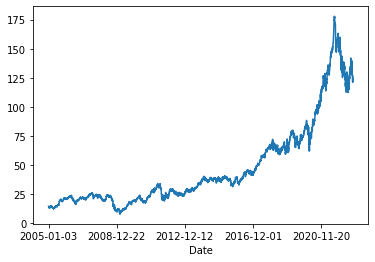

AAPL


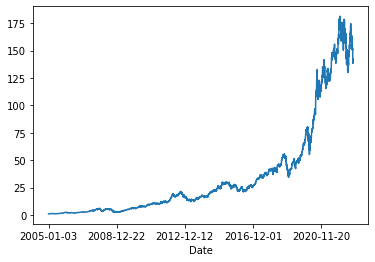

ADBE


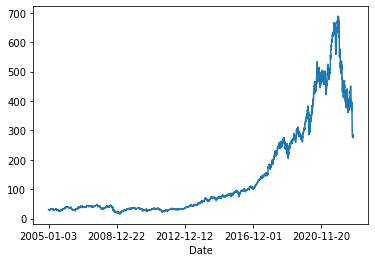

AMD


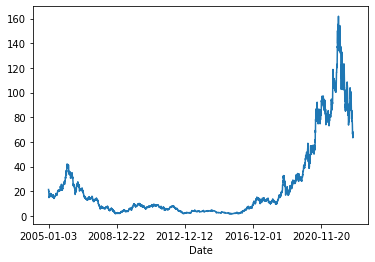

AMZN


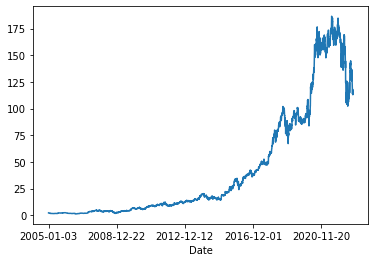

ARE


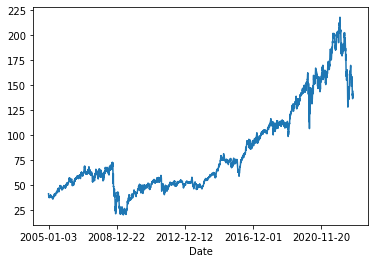

AXP


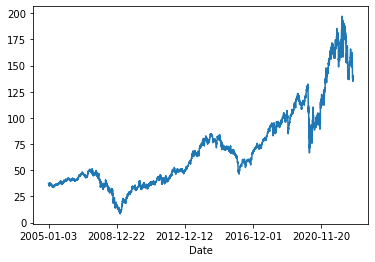

BA


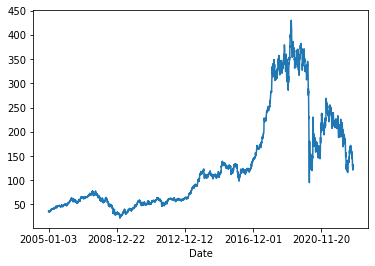

BAC


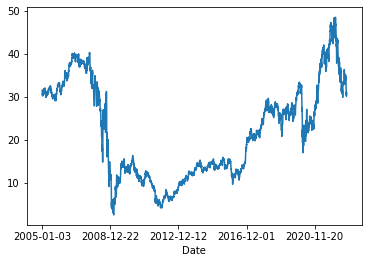

BLK


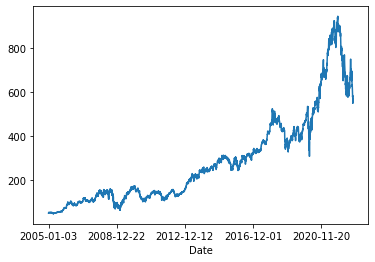

BRK


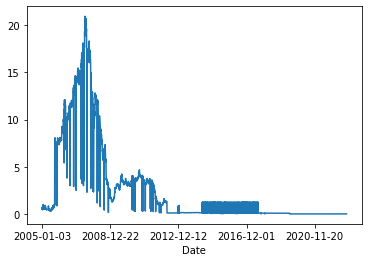

C


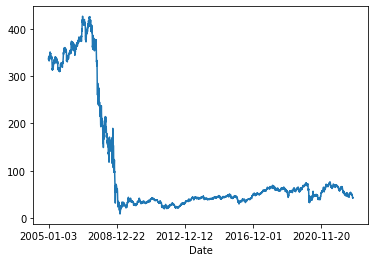

CME


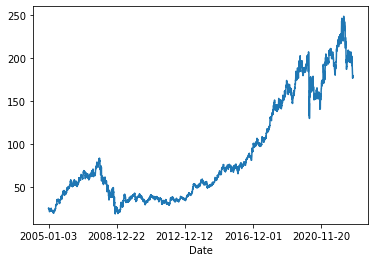

COP


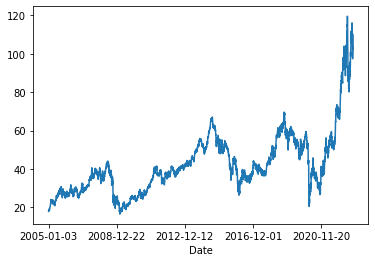

COST


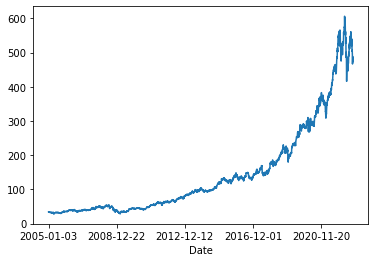

CVX


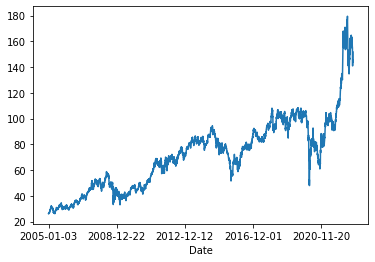

DAL


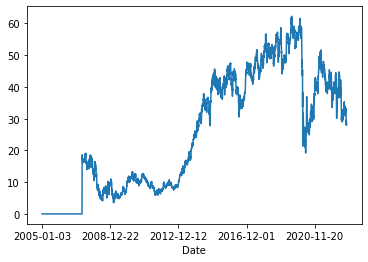

DRE


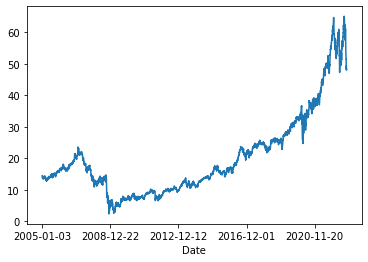

DVN


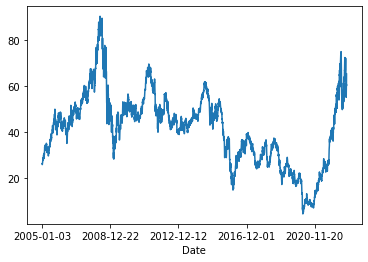

ESS


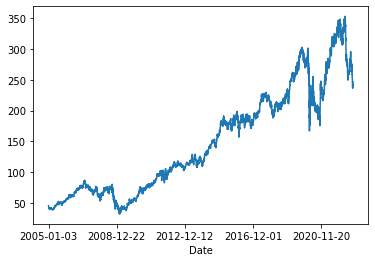

FDX


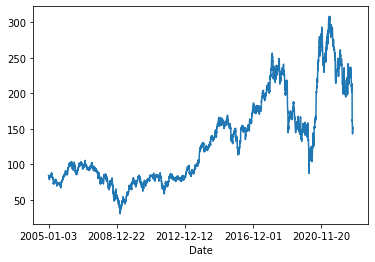

FRT


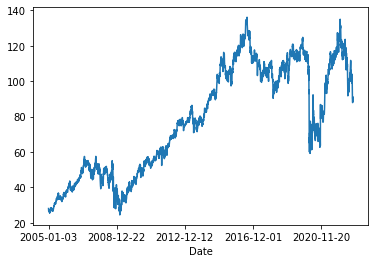

GE


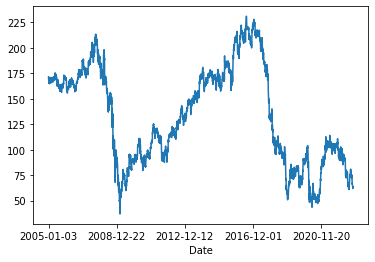

GILD


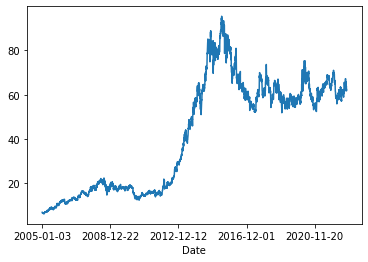

GOOGL


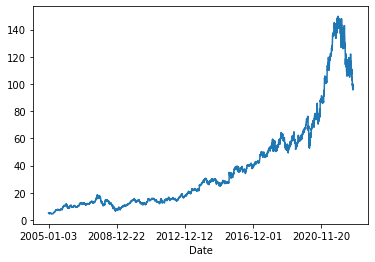

HON


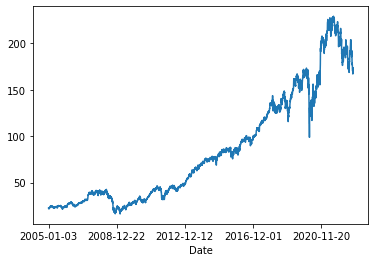

ILMN


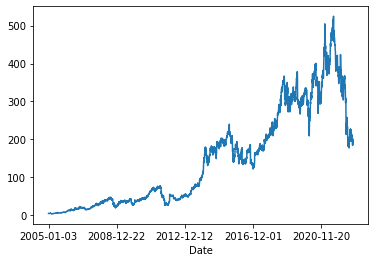

INTC


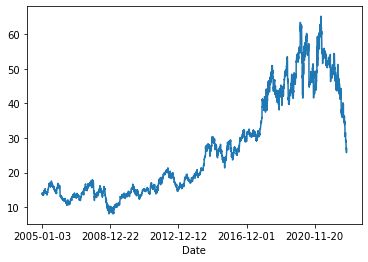

JNJ


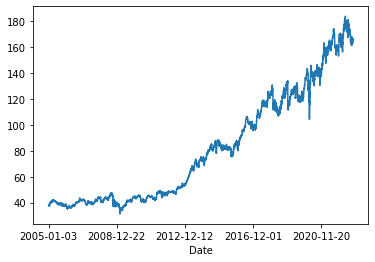

JPM


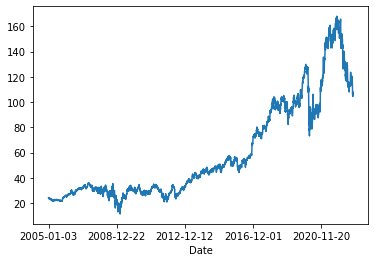

KO


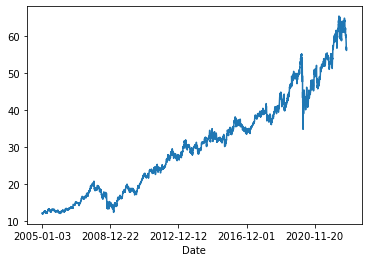

MET


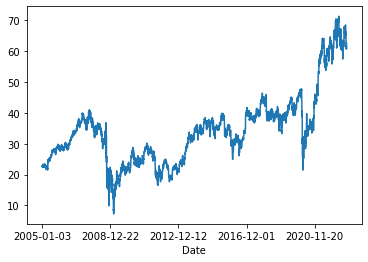

MRK


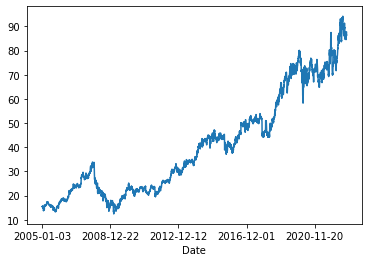

MS


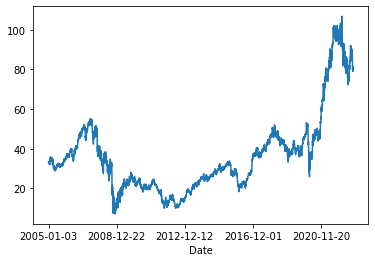

MSFT


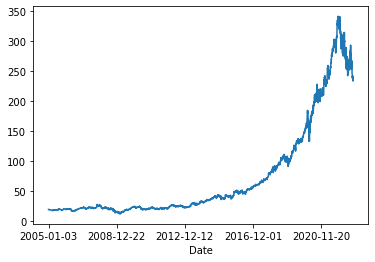

MU


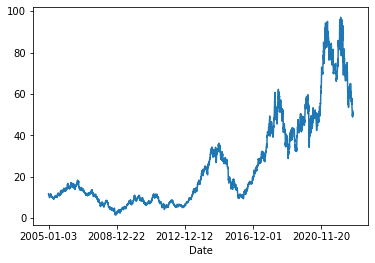

NVDA


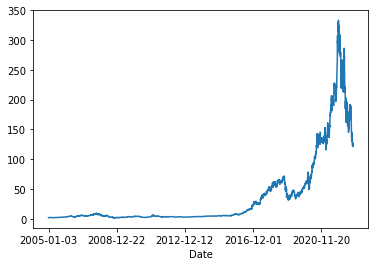

PEAK


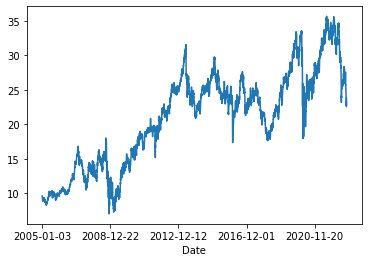

PEP


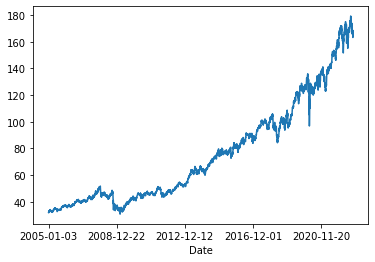

PFE


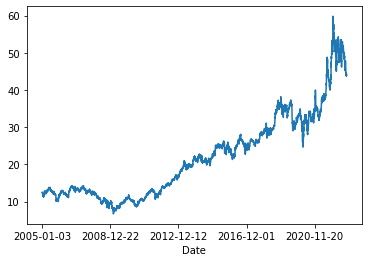

PG


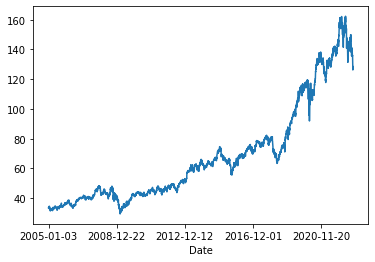

PM


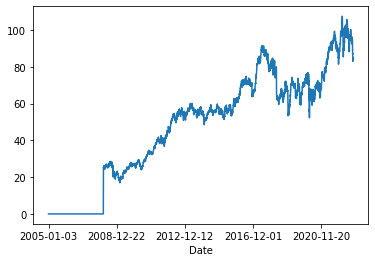

SLB


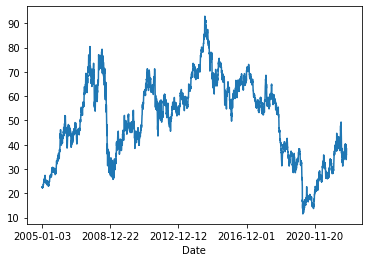

TFX


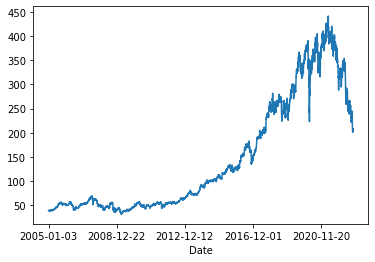

TMO


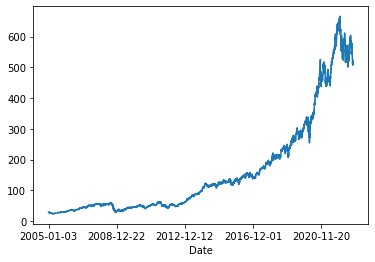

UNH


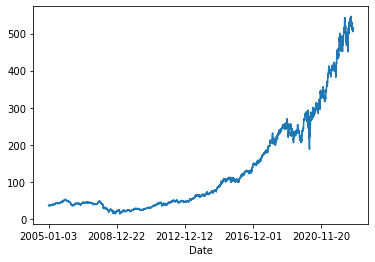

V


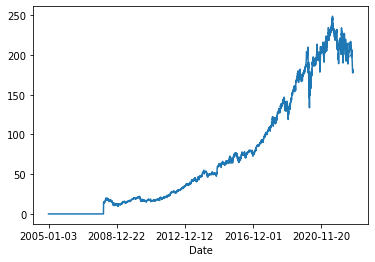

VRTX


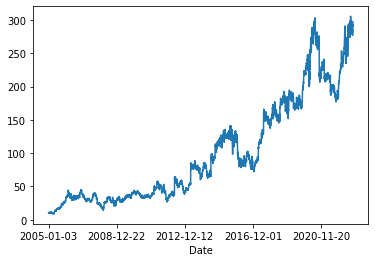

WFC


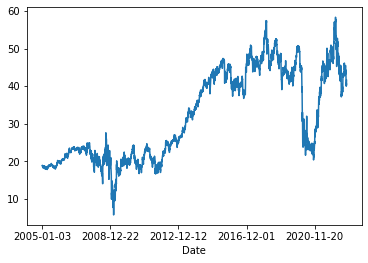

XOM


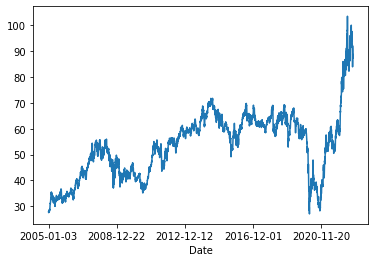

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
for stock in df.ticker.unique():
    stdf = df[df.ticker == stock]
    stdf.set_index('Date', inplace=True)
    print(stock)
    stdf.adjcp.plot()
    plt.show()

In [11]:
0  1.51e+03   -1.38 |   -1.38    1.6    125     0 |   -0.04   0.01   0.05  -0.51
  4%|██▊                                                                             | 1/28 [04:24<1:59:10, 264.82s/it]
0  3.02e+03    3.89 |    3.89    0.1    125     0 |   -0.01   0.00  -0.05  -0.51
  7%|█████▋                                                                          | 2/28 [08:45<1:53:38, 262.26s/it]
0  4.53e+03    3.89 |    1.62    0.0    125     0 |    0.00   0.00  -0.37  -0.51
 11%|████████▌                                                                       | 3/28 [11:46<1:33:46, 225.08s/it]
0  6.03e+03    3.89 |    1.20    0.3    125     0 |   -0.01   0.00   0.21  -0.51
 14%|███████████▍                                                                    | 4/28 [14:53<1:24:04, 210.20s/it]
0  7.54e+03    3.89 |    3.62    0.1    125     0 |    0.00   0.01   0.34  -0.51
 18%|██████████████▎                                                                 | 5/28 [17:56<1:16:47, 200.31s/it]
0  9.04e+03    3.89 |    2.40    0.0    125     0 |   -0.00   0.01   0.21  -0.51
 21%|█████████████████▏                                                              | 6/28 [21:05<1:12:03, 196.53s/it]
0  1.05e+04    3.89 |    1.96    0.0    125     0 |   -0.00   0.00   0.30  -0.51
 25%|████████████████████                                                            | 7/28 [24:17<1:08:18, 195.15s/it]
0  1.21e+04    3.89 |    0.28    0.0    125     0 |   -0.00   0.00   0.10  -0.51
 29%|██████████████████████▊                                                         | 8/28 [27:24<1:04:10, 192.53s/it]
0  1.36e+04    3.89 |    2.68    0.0    125     0 |   -0.00   0.00   0.26  -0.51

0.4

In [ ]:
last = {'eval_time_gap': 8, 'batch_size': 8, 'gamma': 0.98, 'learning_rate': 0.04085,
        'target_step': 58902, 'net_dimension': 1026, 'episode': 11, 'seed': 31}

thriypercent_winner = {'eval_time_gap': 32, 'batch_size': 32, 'gamma': 0.99, 'learning_rate': 0.02799, 'target_step': 80371, 'net_dimension': 100, 'episode': 9, 'seed': 31}
# not stock order the upper hparam